<a href="https://colab.research.google.com/github/mayarj/model_finetune_for_verigen/blob/main/modelFinetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning AI Model for Verilog
This notebook is part of the project aimed at fine-tuning an AI model for Verilog code generation.

## Acknowledgments
This work uses the dataset from the paper "PyraNet: A Neural Network for Verilog Code Generation" (2024). The dataset can be accessed at [bnadimi/PyraNet-Verilog](https://huggingface.co/datasets/bnadimi/PyraNet-Verilog).



In [ ]:
!pip install datasets
from datasets import load_dataset
custom_cache_dir = "./custom_cache_dir"
dataset = load_dataset("bnadimi/PyraNet-Verilog" , cache_dir=custom_cache_dir)
example_instance = dataset['train'][0:5]
print(example_instance)
print("\n")
print (dataset['train']["code"][0:5])

print("\n")
print (dataset['train'][0:5]["code"])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

PyraNetOnVeriBest.csv:   0%|          | 0.00/2.68G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/692238 [00:00<?, ? examples/s]

{'code': ["module VCC (output V);\n   assign V = 1'b1;\nendmodule", 'module pg(\n  input  wire i_a,\n  input  wire i_b,\n  output wire o_p,\n  output wire o_g\n);\n\nassign o_p = i_a ^ i_b;\nassign o_g = i_a & i_b;\n\nendmodule', 'module NOT16(\n    input [15:0] in,\n    output [15:0] out\n);\n\nassign out = ~in;\n\nendmodule', 'module mod(\n\tinput in,\n\toutput out\n);\n\nassign out = in;\n\nendmodule', 'module MyNot(a, z);\n\ninput a;\noutput z;\n\nassign z = ~a;\n\nendmodule'], 'description': ['{"description": "The Verilog code defines a module named `VCC` that outputs a constant high logic level (1). The output `V` is always set to 1.", "rank": "20", "complexity": "Basic", "compile_status": "No error!", "compile_results": ""}', '{"description": "The Verilog code implements a hardware module for generating the propagate (`o_p`) and generate (`o_g`) signals in a binary adder. It computes `o_p` as the XOR of the inputs (`i_a` and `i_b`) and `o_g` as the AND of the same inputs.", "ran

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
import csv
import os
import json
import gc
from tqdm import tqdm
def save_dataset_to_csv_by_complexity(dataset):
    """
    Efficiently saves 700,000+ entry dataset to CSV files by complexity level.
    Provides progress updates and maintains low memory usage.
    """
    # Create output directory
    output_dir = "/content/drive/MyDrive/Verilog_dataset/complexity_datasets"
    os.makedirs(output_dir, exist_ok=True)

    # Track file handles and writers
    complexity_writers = {}
    file_handles = {}

    def init_writer(complexity):
        """Initialize CSV writer for a complexity level"""
        if complexity not in complexity_writers:
            csv_path = os.path.join(output_dir, f"{complexity}.csv")
            fh = open(csv_path, 'w', newline='', encoding='utf-8')
            writer = csv.DictWriter(fh, fieldnames=[
                'code', 'description', 'rank', 'complexity',
                'compile_status', 'compile_results'
            ])
            writer.writeheader()
            complexity_writers[complexity] = writer
            file_handles[complexity] = fh

    total_entries = len(dataset)
    print(f"Processing large dataset ({total_entries:,} entries)...")
    start_time = time.time()
    last_print = start_time

    # Process with manual iteration for better memory control
    for i in tqdm(range(total_entries), desc="Processing", unit="entries"):
        try:
            # Access entry directly (memory efficient)
            entry = dataset[i]

            # Parse the data
            code = entry['code']
            desc_data = entry['description'].replace('\\"', '"')
            desc_dict = json.loads(desc_data)

            # Get fields with defaults
            complexity = desc_dict.get('complexity', 'unknown')
            init_writer(complexity)

            complexity_writers[complexity].writerow({
                'code': code,
                'description': desc_dict.get('description', ''),
                'rank': desc_dict.get('rank', 'unknown'),
                'complexity': complexity,
                'compile_status': desc_dict.get('compile_status', 'unknown'),
                'compile_results': desc_dict.get('compile_results', '')
            })

            # Progress update every 1000 rows with timing info
            if (i + 1) % 1000 == 0:
                current_time = time.time()
                elapsed = current_time - start_time
                items_per_sec = (i + 1) / elapsed
                remaining = (total_entries - (i + 1)) / items_per_sec

                print(
                    f"Processed {i + 1:,} of {total_entries:,} | "
                    f"Speed: {items_per_sec:.1f} entries/sec | "
                    f"ETA: {remaining/60:.1f} minutes remaining"
                )
                last_print = current_time

            # Memory management
            if i % 10000 == 0:
                gc.collect()

        except json.JSONDecodeError as e:
            print(f"\nJSON Error at index {i}: {e}...")
            break
        except Exception as e:
            print(f"\nError at index {i}: {e}...")
            break

    # Cleanup
    for fh in file_handles.values():
        fh.close()

    total_time = (time.time() - start_time)/60
    print(f"\nCompleted processing {total_entries:,} entries in {total_time:.1f} minutes")

save_dataset_to_csv_by_complexity(dataset['train'])

Processing large dataset (692,238 entries)...


Processing:   0%|          | 1368/692238 [00:00<03:19, 3465.88entries/s]

Processed 1,000 of 692,238 | Speed: 2921.7 entries/sec | ETA: 3.9 minutes remaining


Processing:   0%|          | 2656/692238 [00:00<03:21, 3428.93entries/s]

Processed 2,000 of 692,238 | Speed: 2862.0 entries/sec | ETA: 4.0 minutes remaining
Processed 3,000 of 692,238 | Speed: 3361.2 entries/sec | ETA: 3.4 minutes remaining


Processing:   1%|          | 5076/692238 [00:01<02:00, 5695.69entries/s]

Processed 4,000 of 692,238 | Speed: 4044.2 entries/sec | ETA: 2.8 minutes remaining
Processed 5,000 of 692,238 | Speed: 4293.0 entries/sec | ETA: 2.7 minutes remaining


Processing:   1%|          | 6763/692238 [00:01<02:15, 5064.33entries/s]

Processed 6,000 of 692,238 | Speed: 4336.2 entries/sec | ETA: 2.6 minutes remaining


Processing:   1%|          | 7919/692238 [00:01<02:06, 5394.09entries/s]

Processed 7,000 of 692,238 | Speed: 4404.5 entries/sec | ETA: 2.6 minutes remaining
Processed 8,000 of 692,238 | Speed: 4547.7 entries/sec | ETA: 2.5 minutes remaining


Processing:   1%|▏         | 9657/692238 [00:02<02:00, 5663.94entries/s]

Processed 9,000 of 692,238 | Speed: 4670.6 entries/sec | ETA: 2.4 minutes remaining
Processed 10,000 of 692,238 | Speed: 4774.4 entries/sec | ETA: 2.4 minutes remaining


Processing:   2%|▏         | 11958/692238 [00:02<02:11, 5191.36entries/s]

Processed 11,000 of 692,238 | Speed: 4674.2 entries/sec | ETA: 2.4 minutes remaining
Processed 12,000 of 692,238 | Speed: 4728.9 entries/sec | ETA: 2.4 minutes remaining


Processing:   2%|▏         | 13447/692238 [00:02<03:02, 3711.18entries/s]

Processed 13,000 of 692,238 | Speed: 4659.6 entries/sec | ETA: 2.4 minutes remaining


Processing:   2%|▏         | 15192/692238 [00:03<01:54, 5896.35entries/s]

Processed 14,000 of 692,238 | Speed: 4599.6 entries/sec | ETA: 2.5 minutes remaining
Processed 15,000 of 692,238 | Speed: 4755.5 entries/sec | ETA: 2.4 minutes remaining


Processing:   2%|▏         | 16587/692238 [00:03<01:54, 5894.00entries/s]

Processed 16,000 of 692,238 | Speed: 4863.0 entries/sec | ETA: 2.3 minutes remaining
Processed 17,000 of 692,238 | Speed: 4883.9 entries/sec | ETA: 2.3 minutes remaining


Processing:   3%|▎         | 18881/692238 [00:03<02:13, 5037.71entries/s]

Processed 18,000 of 692,238 | Speed: 4856.2 entries/sec | ETA: 2.3 minutes remaining
Processed 19,000 of 692,238 | Speed: 4858.5 entries/sec | ETA: 2.3 minutes remaining


Processing:   3%|▎         | 20951/692238 [00:04<02:33, 4371.08entries/s]

Processed 20,000 of 692,238 | Speed: 4870.6 entries/sec | ETA: 2.3 minutes remaining
Processed 21,000 of 692,238 | Speed: 4789.8 entries/sec | ETA: 2.3 minutes remaining


Processing:   3%|▎         | 22683/692238 [00:04<02:18, 4820.56entries/s]

Processed 22,000 of 692,238 | Speed: 4832.2 entries/sec | ETA: 2.3 minutes remaining
Processed 23,000 of 692,238 | Speed: 4836.3 entries/sec | ETA: 2.3 minutes remaining


Processing:   4%|▎         | 24772/692238 [00:05<02:25, 4590.84entries/s]

Processed 24,000 of 692,238 | Speed: 4839.3 entries/sec | ETA: 2.3 minutes remaining


Processing:   4%|▎         | 25856/692238 [00:05<02:13, 5008.81entries/s]

Processed 25,000 of 692,238 | Speed: 4820.3 entries/sec | ETA: 2.3 minutes remaining
Processed 26,000 of 692,238 | Speed: 4838.2 entries/sec | ETA: 2.3 minutes remaining


Processing:   4%|▍         | 27848/692238 [00:05<02:24, 4593.32entries/s]

Processed 27,000 of 692,238 | Speed: 4834.9 entries/sec | ETA: 2.3 minutes remaining


Processing:   4%|▍         | 28961/692238 [00:05<02:13, 4968.08entries/s]

Processed 28,000 of 692,238 | Speed: 4814.8 entries/sec | ETA: 2.3 minutes remaining
Processed 29,000 of 692,238 | Speed: 4827.6 entries/sec | ETA: 2.3 minutes remaining


Processing:   4%|▍         | 30781/692238 [00:06<02:09, 5107.60entries/s]

Processed 30,000 of 692,238 | Speed: 4854.0 entries/sec | ETA: 2.3 minutes remaining


Processing:   5%|▍         | 32456/692238 [00:06<01:38, 6726.27entries/s]

Processed 31,000 of 692,238 | Speed: 4842.8 entries/sec | ETA: 2.3 minutes remaining
Processed 32,000 of 692,238 | Speed: 4903.7 entries/sec | ETA: 2.2 minutes remaining


Processing:   5%|▍         | 34073/692238 [00:06<01:36, 6807.46entries/s]

Processed 33,000 of 692,238 | Speed: 4976.4 entries/sec | ETA: 2.2 minutes remaining
Processed 34,000 of 692,238 | Speed: 5012.1 entries/sec | ETA: 2.2 minutes remaining


Processing:   5%|▌         | 36041/692238 [00:07<01:53, 5777.57entries/s]

Processed 35,000 of 692,238 | Speed: 5017.4 entries/sec | ETA: 2.2 minutes remaining
Processed 36,000 of 692,238 | Speed: 5027.2 entries/sec | ETA: 2.2 minutes remaining


Processing:   5%|▌         | 37756/692238 [00:07<02:01, 5389.46entries/s]

Processed 37,000 of 692,238 | Speed: 5030.4 entries/sec | ETA: 2.2 minutes remaining
Processed 38,000 of 692,238 | Speed: 5037.4 entries/sec | ETA: 2.2 minutes remaining


Processing:   6%|▌         | 39865/692238 [00:07<02:14, 4835.92entries/s]

Processed 39,000 of 692,238 | Speed: 5039.3 entries/sec | ETA: 2.2 minutes remaining


Processing:   6%|▌         | 40353/692238 [00:08<02:40, 4060.78entries/s]

Processed 40,000 of 692,238 | Speed: 5020.4 entries/sec | ETA: 2.2 minutes remaining


Processing:   6%|▌         | 41988/692238 [00:08<02:12, 4906.98entries/s]

Processed 41,000 of 692,238 | Speed: 4977.1 entries/sec | ETA: 2.2 minutes remaining
Processed 42,000 of 692,238 | Speed: 4987.9 entries/sec | ETA: 2.2 minutes remaining


Processing:   6%|▋         | 43543/692238 [00:08<02:08, 5050.60entries/s]

Processed 43,000 of 692,238 | Speed: 4987.8 entries/sec | ETA: 2.2 minutes remaining
Processed 44,000 of 692,238 | Speed: 4992.0 entries/sec | ETA: 2.2 minutes remaining


Processing:   7%|▋         | 45702/692238 [00:09<02:01, 5328.12entries/s]

Processed 45,000 of 692,238 | Speed: 4999.7 entries/sec | ETA: 2.2 minutes remaining
Processed 46,000 of 692,238 | Speed: 5011.4 entries/sec | ETA: 2.1 minutes remaining


Processing:   7%|▋         | 47863/692238 [00:09<02:04, 5180.38entries/s]

Processed 47,000 of 692,238 | Speed: 5016.0 entries/sec | ETA: 2.1 minutes remaining
Processed 48,000 of 692,238 | Speed: 5019.5 entries/sec | ETA: 2.1 minutes remaining


Processing:   7%|▋         | 49979/692238 [00:09<02:02, 5250.36entries/s]

Processed 49,000 of 692,238 | Speed: 5021.4 entries/sec | ETA: 2.1 minutes remaining
Processed 50,000 of 692,238 | Speed: 5026.6 entries/sec | ETA: 2.1 minutes remaining


Processing:   7%|▋         | 51575/692238 [00:10<02:16, 4708.39entries/s]

Processed 51,000 of 692,238 | Speed: 4990.4 entries/sec | ETA: 2.1 minutes remaining
Processed 52,000 of 692,238 | Speed: 4995.7 entries/sec | ETA: 2.1 minutes remaining


Processing:   8%|▊         | 53673/692238 [00:10<02:05, 5103.19entries/s]

Processed 53,000 of 692,238 | Speed: 4999.7 entries/sec | ETA: 2.1 minutes remaining
Processed 54,000 of 692,238 | Speed: 4998.2 entries/sec | ETA: 2.1 minutes remaining


Processing:   8%|▊         | 55373/692238 [00:11<03:20, 3177.73entries/s]

Processed 55,000 of 692,238 | Speed: 4894.9 entries/sec | ETA: 2.2 minutes remaining


Processing:   8%|▊         | 56051/692238 [00:11<03:18, 3206.17entries/s]

Processed 56,000 of 692,238 | Speed: 4841.2 entries/sec | ETA: 2.2 minutes remaining


Processing:   8%|▊         | 57647/692238 [00:12<03:38, 2906.75entries/s]

Processed 57,000 of 692,238 | Speed: 4728.2 entries/sec | ETA: 2.2 minutes remaining


Processing:   8%|▊         | 57968/692238 [00:12<03:32, 2987.95entries/s]

Processed 58,000 of 692,238 | Speed: 4695.5 entries/sec | ETA: 2.3 minutes remaining


Processing:   9%|▊         | 59526/692238 [00:13<04:12, 2503.11entries/s]

Processed 59,000 of 692,238 | Speed: 4547.0 entries/sec | ETA: 2.3 minutes remaining


Processing:   9%|▊         | 60104/692238 [00:13<05:02, 2089.59entries/s]

Processed 60,000 of 692,238 | Speed: 4505.6 entries/sec | ETA: 2.3 minutes remaining


Processing:   9%|▉         | 61332/692238 [00:13<03:50, 2732.02entries/s]

Processed 61,000 of 692,238 | Speed: 4437.8 entries/sec | ETA: 2.4 minutes remaining


Processing:   9%|▉         | 62484/692238 [00:14<03:59, 2627.01entries/s]

Processed 62,000 of 692,238 | Speed: 4395.9 entries/sec | ETA: 2.4 minutes remaining


Processing:   9%|▉         | 63572/692238 [00:14<03:11, 3279.87entries/s]

Processed 63,000 of 692,238 | Speed: 4361.8 entries/sec | ETA: 2.4 minutes remaining


Processing:   9%|▉         | 64909/692238 [00:14<02:27, 4261.27entries/s]

Processed 64,000 of 692,238 | Speed: 4347.7 entries/sec | ETA: 2.4 minutes remaining
Processed 65,000 of 692,238 | Speed: 4358.5 entries/sec | ETA: 2.4 minutes remaining


Processing:  10%|▉         | 66556/692238 [00:15<02:03, 5065.68entries/s]

Processed 66,000 of 692,238 | Speed: 4373.6 entries/sec | ETA: 2.4 minutes remaining
Processed 67,000 of 692,238 | Speed: 4382.0 entries/sec | ETA: 2.4 minutes remaining


Processing:  10%|▉         | 68685/692238 [00:15<02:04, 5019.72entries/s]

Processed 68,000 of 692,238 | Speed: 4392.6 entries/sec | ETA: 2.4 minutes remaining
Processed 69,000 of 692,238 | Speed: 4402.6 entries/sec | ETA: 2.4 minutes remaining


Processing:  10%|█         | 70547/692238 [00:16<02:08, 4843.54entries/s]

Processed 70,000 of 692,238 | Speed: 4424.4 entries/sec | ETA: 2.3 minutes remaining
Processed 71,000 of 692,238 | Speed: 4413.2 entries/sec | ETA: 2.3 minutes remaining


Processing:  11%|█         | 73507/692238 [00:16<01:29, 6919.59entries/s]

Processed 72,000 of 692,238 | Speed: 4438.3 entries/sec | ETA: 2.3 minutes remaining
Processed 73,000 of 692,238 | Speed: 4461.9 entries/sec | ETA: 2.3 minutes remaining


Processing:  11%|█         | 75130/692238 [00:16<01:24, 7324.08entries/s]

Processed 74,000 of 692,238 | Speed: 4492.7 entries/sec | ETA: 2.3 minutes remaining
Processed 75,000 of 692,238 | Speed: 4518.1 entries/sec | ETA: 2.3 minutes remaining


Processing:  11%|█         | 77456/692238 [00:16<01:21, 7568.87entries/s]

Processed 76,000 of 692,238 | Speed: 4538.0 entries/sec | ETA: 2.3 minutes remaining
Processed 77,000 of 692,238 | Speed: 4562.9 entries/sec | ETA: 2.2 minutes remaining


Processing:  11%|█▏        | 79138/692238 [00:17<01:17, 7921.89entries/s]

Processed 78,000 of 692,238 | Speed: 4585.8 entries/sec | ETA: 2.2 minutes remaining
Processed 79,000 of 692,238 | Speed: 4613.9 entries/sec | ETA: 2.2 minutes remaining


Processing:  12%|█▏        | 80728/692238 [00:17<01:35, 6416.36entries/s]

Processed 80,000 of 692,238 | Speed: 4637.9 entries/sec | ETA: 2.2 minutes remaining
Processed 81,000 of 692,238 | Speed: 4640.9 entries/sec | ETA: 2.2 minutes remaining


Processing:  12%|█▏        | 82966/692238 [00:17<01:25, 7093.17entries/s]

Processed 82,000 of 692,238 | Speed: 4661.2 entries/sec | ETA: 2.2 minutes remaining
Processed 83,000 of 692,238 | Speed: 4682.8 entries/sec | ETA: 2.2 minutes remaining


Processing:  12%|█▏        | 85404/692238 [00:18<01:17, 7804.85entries/s]

Processed 84,000 of 692,238 | Speed: 4705.8 entries/sec | ETA: 2.2 minutes remaining
Processed 85,000 of 692,238 | Speed: 4728.9 entries/sec | ETA: 2.1 minutes remaining


Processing:  13%|█▎        | 86906/692238 [00:18<01:36, 6300.03entries/s]

Processed 86,000 of 692,238 | Speed: 4743.2 entries/sec | ETA: 2.1 minutes remaining
Processed 87,000 of 692,238 | Speed: 4746.6 entries/sec | ETA: 2.1 minutes remaining


Processing:  13%|█▎        | 88722/692238 [00:18<01:53, 5316.51entries/s]

Processed 88,000 of 692,238 | Speed: 4747.7 entries/sec | ETA: 2.1 minutes remaining


Processing:  13%|█▎        | 89814/692238 [00:18<01:57, 5113.08entries/s]

Processed 89,000 of 692,238 | Speed: 4744.3 entries/sec | ETA: 2.1 minutes remaining
Processed 90,000 of 692,238 | Speed: 4747.4 entries/sec | ETA: 2.1 minutes remaining


Processing:  13%|█▎        | 91868/692238 [00:19<02:10, 4593.65entries/s]

Processed 91,000 of 692,238 | Speed: 4730.1 entries/sec | ETA: 2.1 minutes remaining
Processed 92,000 of 692,238 | Speed: 4732.6 entries/sec | ETA: 2.1 minutes remaining


Processing:  14%|█▎        | 93993/692238 [00:19<01:57, 5099.87entries/s]

Processed 93,000 of 692,238 | Speed: 4738.7 entries/sec | ETA: 2.1 minutes remaining
Processed 94,000 of 692,238 | Speed: 4742.8 entries/sec | ETA: 2.1 minutes remaining


Processing:  14%|█▍        | 95583/692238 [00:20<01:54, 5213.40entries/s]

Processed 95,000 of 692,238 | Speed: 4749.0 entries/sec | ETA: 2.1 minutes remaining
Processed 96,000 of 692,238 | Speed: 4753.2 entries/sec | ETA: 2.1 minutes remaining


Processing:  14%|█▍        | 97662/692238 [00:20<02:02, 4857.88entries/s]

Processed 97,000 of 692,238 | Speed: 4756.7 entries/sec | ETA: 2.1 minutes remaining


Processing:  14%|█▍        | 98716/692238 [00:20<02:03, 4794.80entries/s]

Processed 98,000 of 692,238 | Speed: 4748.7 entries/sec | ETA: 2.1 minutes remaining
Processed 99,000 of 692,238 | Speed: 4751.9 entries/sec | ETA: 2.1 minutes remaining


Processing:  15%|█▍        | 100728/692238 [00:21<02:18, 4284.85entries/s]

Processed 100,000 of 692,238 | Speed: 4755.4 entries/sec | ETA: 2.1 minutes remaining
Processed 101,000 of 692,238 | Speed: 4739.4 entries/sec | ETA: 2.1 minutes remaining


Processing:  15%|█▍        | 102701/692238 [00:21<02:04, 4738.88entries/s]

Processed 102,000 of 692,238 | Speed: 4739.8 entries/sec | ETA: 2.1 minutes remaining
Processed 103,000 of 692,238 | Speed: 4744.1 entries/sec | ETA: 2.1 minutes remaining


Processing:  15%|█▌        | 104785/692238 [00:22<01:55, 5085.36entries/s]

Processed 104,000 of 692,238 | Speed: 4747.5 entries/sec | ETA: 2.1 minutes remaining
Processed 105,000 of 692,238 | Speed: 4751.8 entries/sec | ETA: 2.1 minutes remaining


Processing:  15%|█▌        | 106835/692238 [00:22<01:55, 5051.23entries/s]

Processed 106,000 of 692,238 | Speed: 4752.8 entries/sec | ETA: 2.1 minutes remaining


Processing:  16%|█▌        | 107831/692238 [00:22<02:06, 4617.58entries/s]

Processed 107,000 of 692,238 | Speed: 4752.6 entries/sec | ETA: 2.1 minutes remaining


Processing:  16%|█▌        | 108911/692238 [00:22<01:56, 5005.02entries/s]

Processed 108,000 of 692,238 | Speed: 4751.4 entries/sec | ETA: 2.0 minutes remaining
Processed 109,000 of 692,238 | Speed: 4756.9 entries/sec | ETA: 2.0 minutes remaining


Processing:  16%|█▌        | 110968/692238 [00:23<02:12, 4373.07entries/s]

Processed 110,000 of 692,238 | Speed: 4759.4 entries/sec | ETA: 2.0 minutes remaining
Processed 111,000 of 692,238 | Speed: 4746.7 entries/sec | ETA: 2.0 minutes remaining


Processing:  16%|█▋        | 113006/692238 [00:23<01:59, 4840.50entries/s]

Processed 112,000 of 692,238 | Speed: 4746.1 entries/sec | ETA: 2.0 minutes remaining
Processed 113,000 of 692,238 | Speed: 4750.8 entries/sec | ETA: 2.0 minutes remaining


Processing:  17%|█▋        | 114575/692238 [00:24<01:53, 5109.10entries/s]

Processed 114,000 of 692,238 | Speed: 4754.4 entries/sec | ETA: 2.0 minutes remaining
Processed 115,000 of 692,238 | Speed: 4758.6 entries/sec | ETA: 2.0 minutes remaining


Processing:  17%|█▋        | 116781/692238 [00:24<01:46, 5421.78entries/s]

Processed 116,000 of 692,238 | Speed: 4762.2 entries/sec | ETA: 2.0 minutes remaining
Processed 117,000 of 692,238 | Speed: 4768.2 entries/sec | ETA: 2.0 minutes remaining


Processing:  17%|█▋        | 118349/692238 [00:24<01:56, 4940.67entries/s]

Processed 118,000 of 692,238 | Speed: 4768.4 entries/sec | ETA: 2.0 minutes remaining


Processing:  17%|█▋        | 119297/692238 [00:25<02:29, 3823.73entries/s]

Processed 119,000 of 692,238 | Speed: 4752.4 entries/sec | ETA: 2.0 minutes remaining


Processing:  17%|█▋        | 120020/692238 [00:25<04:13, 2257.34entries/s]

Processed 120,000 of 692,238 | Speed: 4702.8 entries/sec | ETA: 2.0 minutes remaining


Processing:  18%|█▊        | 121350/692238 [00:26<03:13, 2951.79entries/s]

Processed 121,000 of 692,238 | Speed: 4666.3 entries/sec | ETA: 2.0 minutes remaining


Processing:  18%|█▊        | 122674/692238 [00:26<02:56, 3224.59entries/s]

Processed 122,000 of 692,238 | Speed: 4648.4 entries/sec | ETA: 2.0 minutes remaining


Processing:  18%|█▊        | 123334/692238 [00:26<02:55, 3234.99entries/s]

Processed 123,000 of 692,238 | Speed: 4634.4 entries/sec | ETA: 2.0 minutes remaining


Processing:  18%|█▊        | 124329/692238 [00:26<02:57, 3206.59entries/s]

Processed 124,000 of 692,238 | Speed: 4618.4 entries/sec | ETA: 2.1 minutes remaining


Processing:  18%|█▊        | 125352/692238 [00:27<02:53, 3259.19entries/s]

Processed 125,000 of 692,238 | Speed: 4604.3 entries/sec | ETA: 2.1 minutes remaining


Processing:  18%|█▊        | 126313/692238 [00:27<03:05, 3046.86entries/s]

Processed 126,000 of 692,238 | Speed: 4585.1 entries/sec | ETA: 2.1 minutes remaining


Processing:  18%|█▊        | 127583/692238 [00:27<03:01, 3106.95entries/s]

Processed 127,000 of 692,238 | Speed: 4564.5 entries/sec | ETA: 2.1 minutes remaining


Processing:  19%|█▊        | 128544/692238 [00:28<02:59, 3137.70entries/s]

Processed 128,000 of 692,238 | Speed: 4548.1 entries/sec | ETA: 2.1 minutes remaining


Processing:  19%|█▊        | 129668/692238 [00:28<02:36, 3592.97entries/s]

Processed 129,000 of 692,238 | Speed: 4533.7 entries/sec | ETA: 2.1 minutes remaining


Processing:  19%|█▉        | 130530/692238 [00:28<02:37, 3559.00entries/s]

Processed 130,000 of 692,238 | Speed: 4532.1 entries/sec | ETA: 2.1 minutes remaining


Processing:  19%|█▉        | 132030/692238 [00:29<02:05, 4481.63entries/s]

Processed 131,000 of 692,238 | Speed: 4520.4 entries/sec | ETA: 2.1 minutes remaining
Processed 132,000 of 692,238 | Speed: 4525.0 entries/sec | ETA: 2.1 minutes remaining


Processing:  19%|█▉        | 133491/692238 [00:29<02:19, 3993.62entries/s]

Processed 133,000 of 692,238 | Speed: 4528.2 entries/sec | ETA: 2.1 minutes remaining


Processing:  19%|█▉        | 134291/692238 [00:29<02:42, 3426.59entries/s]

Processed 134,000 of 692,238 | Speed: 4508.8 entries/sec | ETA: 2.1 minutes remaining


Processing:  20%|█▉        | 135577/692238 [00:30<03:06, 2980.92entries/s]

Processed 135,000 of 692,238 | Speed: 4484.6 entries/sec | ETA: 2.1 minutes remaining


Processing:  20%|█▉        | 137038/692238 [00:30<02:09, 4270.94entries/s]

Processed 136,000 of 692,238 | Speed: 4472.8 entries/sec | ETA: 2.1 minutes remaining
Processed 137,000 of 692,238 | Speed: 4479.3 entries/sec | ETA: 2.1 minutes remaining


Processing:  20%|██        | 138540/692238 [00:30<01:56, 4762.29entries/s]

Processed 138,000 of 692,238 | Speed: 4482.3 entries/sec | ETA: 2.1 minutes remaining
Processed 139,000 of 692,238 | Speed: 4486.1 entries/sec | ETA: 2.1 minutes remaining


Processing:  20%|██        | 140044/692238 [00:31<02:30, 3674.61entries/s]

Processed 140,000 of 692,238 | Speed: 4489.0 entries/sec | ETA: 2.1 minutes remaining


Processing:  20%|██        | 141585/692238 [00:31<02:02, 4509.49entries/s]

Processed 141,000 of 692,238 | Speed: 4477.9 entries/sec | ETA: 2.1 minutes remaining
Processed 142,000 of 692,238 | Speed: 4480.7 entries/sec | ETA: 2.0 minutes remaining


Processing:  21%|██        | 143571/692238 [00:32<01:59, 4577.85entries/s]

Processed 143,000 of 692,238 | Speed: 4477.0 entries/sec | ETA: 2.0 minutes remaining
Processed 144,000 of 692,238 | Speed: 4480.3 entries/sec | ETA: 2.0 minutes remaining


Processing:  21%|██        | 145748/692238 [00:32<01:43, 5279.97entries/s]

Processed 145,000 of 692,238 | Speed: 4484.9 entries/sec | ETA: 2.0 minutes remaining
Processed 146,000 of 692,238 | Speed: 4491.4 entries/sec | ETA: 2.0 minutes remaining


Processing:  21%|██▏       | 147883/692238 [00:32<01:45, 5140.56entries/s]

Processed 147,000 of 692,238 | Speed: 4495.8 entries/sec | ETA: 2.0 minutes remaining
Processed 148,000 of 692,238 | Speed: 4498.9 entries/sec | ETA: 2.0 minutes remaining


Processing:  22%|██▏       | 149971/692238 [00:33<01:47, 5039.06entries/s]

Processed 149,000 of 692,238 | Speed: 4500.8 entries/sec | ETA: 2.0 minutes remaining
Processed 150,000 of 692,238 | Speed: 4505.0 entries/sec | ETA: 2.0 minutes remaining


Processing:  22%|██▏       | 151468/692238 [00:33<02:02, 4401.49entries/s]

Processed 151,000 of 692,238 | Speed: 4495.7 entries/sec | ETA: 2.0 minutes remaining


Processing:  22%|██▏       | 152948/692238 [00:34<01:59, 4521.23entries/s]

Processed 152,000 of 692,238 | Speed: 4494.8 entries/sec | ETA: 2.0 minutes remaining


Processing:  22%|██▏       | 153959/692238 [00:34<01:53, 4742.88entries/s]

Processed 153,000 of 692,238 | Speed: 4497.2 entries/sec | ETA: 2.0 minutes remaining
Processed 154,000 of 692,238 | Speed: 4500.2 entries/sec | ETA: 2.0 minutes remaining


Processing:  23%|██▎       | 155841/692238 [00:34<01:30, 5910.38entries/s]

Processed 155,000 of 692,238 | Speed: 4505.9 entries/sec | ETA: 2.0 minutes remaining
Processed 156,000 of 692,238 | Speed: 4517.2 entries/sec | ETA: 2.0 minutes remaining


Processing:  23%|██▎       | 158041/692238 [00:34<01:17, 6886.36entries/s]

Processed 157,000 of 692,238 | Speed: 4527.9 entries/sec | ETA: 2.0 minutes remaining
Processed 158,000 of 692,238 | Speed: 4539.5 entries/sec | ETA: 2.0 minutes remaining


Processing:  23%|██▎       | 159523/692238 [00:35<01:18, 6806.83entries/s]

Processed 159,000 of 692,238 | Speed: 4550.8 entries/sec | ETA: 2.0 minutes remaining
Processed 160,000 of 692,238 | Speed: 4556.0 entries/sec | ETA: 1.9 minutes remaining


Processing:  23%|██▎       | 161846/692238 [00:35<01:48, 4883.78entries/s]

Processed 161,000 of 692,238 | Speed: 4544.8 entries/sec | ETA: 1.9 minutes remaining


Processing:  24%|██▎       | 162872/692238 [00:35<01:50, 4791.77entries/s]

Processed 162,000 of 692,238 | Speed: 4545.9 entries/sec | ETA: 1.9 minutes remaining


Processing:  24%|██▎       | 163898/692238 [00:36<01:46, 4938.02entries/s]

Processed 163,000 of 692,238 | Speed: 4547.1 entries/sec | ETA: 1.9 minutes remaining
Processed 164,000 of 692,238 | Speed: 4549.5 entries/sec | ETA: 1.9 minutes remaining


Processing:  24%|██▍       | 165928/692238 [00:36<01:47, 4885.72entries/s]

Processed 165,000 of 692,238 | Speed: 4548.3 entries/sec | ETA: 1.9 minutes remaining
Processed 166,000 of 692,238 | Speed: 4551.5 entries/sec | ETA: 1.9 minutes remaining


Processing:  24%|██▍       | 167936/692238 [00:36<01:47, 4891.55entries/s]

Processed 167,000 of 692,238 | Speed: 4554.5 entries/sec | ETA: 1.9 minutes remaining


Processing:  24%|██▍       | 168947/692238 [00:37<01:47, 4859.76entries/s]

Processed 168,000 of 692,238 | Speed: 4555.1 entries/sec | ETA: 1.9 minutes remaining
Processed 169,000 of 692,238 | Speed: 4557.1 entries/sec | ETA: 1.9 minutes remaining


Processing:  25%|██▍       | 170408/692238 [00:37<02:20, 3716.64entries/s]

Processed 170,000 of 692,238 | Speed: 4557.8 entries/sec | ETA: 1.9 minutes remaining


Processing:  25%|██▍       | 171943/692238 [00:37<01:54, 4549.10entries/s]

Processed 171,000 of 692,238 | Speed: 4548.1 entries/sec | ETA: 1.9 minutes remaining
Processed 172,000 of 692,238 | Speed: 4550.7 entries/sec | ETA: 1.9 minutes remaining


Processing:  25%|██▌       | 173861/692238 [00:38<01:50, 4683.50entries/s]

Processed 173,000 of 692,238 | Speed: 4552.1 entries/sec | ETA: 1.9 minutes remaining


Processing:  25%|██▌       | 174850/692238 [00:38<01:50, 4701.65entries/s]

Processed 174,000 of 692,238 | Speed: 4552.9 entries/sec | ETA: 1.9 minutes remaining


Processing:  25%|██▌       | 175325/692238 [00:38<01:51, 4620.95entries/s]

Processed 175,000 of 692,238 | Speed: 4553.0 entries/sec | ETA: 1.9 minutes remaining


Processing:  26%|██▌       | 176594/692238 [00:38<02:24, 3571.47entries/s]

Processed 176,000 of 692,238 | Speed: 4544.0 entries/sec | ETA: 1.9 minutes remaining


Processing:  26%|██▌       | 177315/692238 [00:39<02:34, 3339.53entries/s]

Processed 177,000 of 692,238 | Speed: 4533.6 entries/sec | ETA: 1.9 minutes remaining


Processing:  26%|██▌       | 178661/692238 [00:39<02:41, 3173.38entries/s]

Processed 178,000 of 692,238 | Speed: 4517.9 entries/sec | ETA: 1.9 minutes remaining


Processing:  26%|██▌       | 179616/692238 [00:39<02:44, 3125.53entries/s]

Processed 179,000 of 692,238 | Speed: 4508.8 entries/sec | ETA: 1.9 minutes remaining


Processing:  26%|██▌       | 180279/692238 [00:40<03:13, 2646.23entries/s]

Processed 180,000 of 692,238 | Speed: 4499.1 entries/sec | ETA: 1.9 minutes remaining


Processing:  26%|██▌       | 181345/692238 [00:40<02:59, 2838.83entries/s]

Processed 181,000 of 692,238 | Speed: 4482.9 entries/sec | ETA: 1.9 minutes remaining


Processing:  26%|██▋       | 182462/692238 [00:40<03:11, 2657.96entries/s]

Processed 182,000 of 692,238 | Speed: 4462.8 entries/sec | ETA: 1.9 minutes remaining


Processing:  26%|██▋       | 183301/692238 [00:41<03:08, 2699.89entries/s]

Processed 183,000 of 692,238 | Speed: 4446.5 entries/sec | ETA: 1.9 minutes remaining


Processing:  27%|██▋       | 184372/692238 [00:41<03:16, 2584.36entries/s]

Processed 184,000 of 692,238 | Speed: 4428.1 entries/sec | ETA: 1.9 minutes remaining


Processing:  27%|██▋       | 185316/692238 [00:41<02:51, 2955.99entries/s]

Processed 185,000 of 692,238 | Speed: 4416.4 entries/sec | ETA: 1.9 minutes remaining


Processing:  27%|██▋       | 186604/692238 [00:42<02:40, 3154.31entries/s]

Processed 186,000 of 692,238 | Speed: 4406.8 entries/sec | ETA: 1.9 minutes remaining


Processing:  27%|██▋       | 187871/692238 [00:42<02:12, 3813.62entries/s]

Processed 187,000 of 692,238 | Speed: 4397.3 entries/sec | ETA: 1.9 minutes remaining


Processing:  27%|██▋       | 189096/692238 [00:42<01:41, 4975.48entries/s]

Processed 188,000 of 692,238 | Speed: 4398.9 entries/sec | ETA: 1.9 minutes remaining
Processed 189,000 of 692,238 | Speed: 4406.4 entries/sec | ETA: 1.9 minutes remaining


Processing:  28%|██▊       | 190804/692238 [00:43<01:47, 4683.25entries/s]

Processed 190,000 of 692,238 | Speed: 4412.7 entries/sec | ETA: 1.9 minutes remaining
Processed 191,000 of 692,238 | Speed: 4410.1 entries/sec | ETA: 1.9 minutes remaining


Processing:  28%|██▊       | 192866/692238 [00:43<01:22, 6048.88entries/s]

Processed 192,000 of 692,238 | Speed: 4418.1 entries/sec | ETA: 1.9 minutes remaining
Processed 193,000 of 692,238 | Speed: 4426.6 entries/sec | ETA: 1.9 minutes remaining


Processing:  28%|██▊       | 195051/692238 [00:43<01:12, 6815.86entries/s]

Processed 194,000 of 692,238 | Speed: 4435.6 entries/sec | ETA: 1.9 minutes remaining
Processed 195,000 of 692,238 | Speed: 4444.3 entries/sec | ETA: 1.9 minutes remaining


Processing:  28%|██▊       | 197267/692238 [00:44<01:10, 7005.97entries/s]

Processed 196,000 of 692,238 | Speed: 4453.0 entries/sec | ETA: 1.9 minutes remaining
Processed 197,000 of 692,238 | Speed: 4462.2 entries/sec | ETA: 1.8 minutes remaining


Processing:  29%|██▊       | 198809/692238 [00:44<01:06, 7366.56entries/s]

Processed 198,000 of 692,238 | Speed: 4470.8 entries/sec | ETA: 1.8 minutes remaining
Processed 199,000 of 692,238 | Speed: 4479.4 entries/sec | ETA: 1.8 minutes remaining


Processing:  29%|██▉       | 201066/692238 [00:44<01:20, 6076.95entries/s]

Processed 200,000 of 692,238 | Speed: 4485.9 entries/sec | ETA: 1.8 minutes remaining
Processed 201,000 of 692,238 | Speed: 4486.3 entries/sec | ETA: 1.8 minutes remaining


Processing:  29%|██▉       | 202939/692238 [00:45<01:31, 5328.43entries/s]

Processed 202,000 of 692,238 | Speed: 4489.8 entries/sec | ETA: 1.8 minutes remaining


Processing:  29%|██▉       | 203495/692238 [00:45<01:34, 5155.49entries/s]

Processed 203,000 of 692,238 | Speed: 4490.6 entries/sec | ETA: 1.8 minutes remaining


Processing:  30%|██▉       | 204527/692238 [00:45<01:43, 4706.24entries/s]

Processed 204,000 of 692,238 | Speed: 4491.5 entries/sec | ETA: 1.8 minutes remaining


Processing:  30%|██▉       | 205451/692238 [00:45<01:55, 4205.89entries/s]

Processed 205,000 of 692,238 | Speed: 4488.6 entries/sec | ETA: 1.8 minutes remaining


Processing:  30%|██▉       | 206899/692238 [00:46<01:44, 4646.16entries/s]

Processed 206,000 of 692,238 | Speed: 4486.5 entries/sec | ETA: 1.8 minutes remaining
Processed 207,000 of 692,238 | Speed: 4488.8 entries/sec | ETA: 1.8 minutes remaining


Processing:  30%|███       | 208754/692238 [00:46<01:48, 4439.73entries/s]

Processed 208,000 of 692,238 | Speed: 4486.9 entries/sec | ETA: 1.8 minutes remaining


Processing:  30%|███       | 209634/692238 [00:46<01:52, 4297.22entries/s]

Processed 209,000 of 692,238 | Speed: 4486.3 entries/sec | ETA: 1.8 minutes remaining


Processing:  30%|███       | 210564/692238 [00:47<02:03, 3898.61entries/s]

Processed 210,000 of 692,238 | Speed: 4486.4 entries/sec | ETA: 1.8 minutes remaining


Processing:  31%|███       | 211504/692238 [00:47<01:52, 4277.98entries/s]

Processed 211,000 of 692,238 | Speed: 4479.4 entries/sec | ETA: 1.8 minutes remaining


Processing:  31%|███       | 212951/692238 [00:47<01:46, 4509.18entries/s]

Processed 212,000 of 692,238 | Speed: 4481.0 entries/sec | ETA: 1.8 minutes remaining


Processing:  31%|███       | 213860/692238 [00:47<01:52, 4267.78entries/s]

Processed 213,000 of 692,238 | Speed: 4480.9 entries/sec | ETA: 1.8 minutes remaining


Processing:  31%|███       | 214821/692238 [00:47<01:45, 4535.73entries/s]

Processed 214,000 of 692,238 | Speed: 4479.5 entries/sec | ETA: 1.8 minutes remaining


Processing:  31%|███       | 215758/692238 [00:48<01:43, 4614.05entries/s]

Processed 215,000 of 692,238 | Speed: 4480.6 entries/sec | ETA: 1.8 minutes remaining


Processing:  31%|███▏      | 216757/692238 [00:48<01:39, 4782.50entries/s]

Processed 216,000 of 692,238 | Speed: 4481.4 entries/sec | ETA: 1.8 minutes remaining
Processed 217,000 of 692,238 | Speed: 4483.8 entries/sec | ETA: 1.8 minutes remaining


Processing:  32%|███▏      | 218759/692238 [00:48<01:47, 4399.68entries/s]

Processed 218,000 of 692,238 | Speed: 4485.8 entries/sec | ETA: 1.8 minutes remaining


Processing:  32%|███▏      | 219785/692238 [00:48<01:39, 4745.14entries/s]

Processed 219,000 of 692,238 | Speed: 4483.0 entries/sec | ETA: 1.8 minutes remaining
Processed 220,000 of 692,238 | Speed: 4486.1 entries/sec | ETA: 1.8 minutes remaining


Processing:  32%|███▏      | 221359/692238 [00:49<02:35, 3025.59entries/s]

Processed 221,000 of 692,238 | Speed: 4465.4 entries/sec | ETA: 1.8 minutes remaining


Processing:  32%|███▏      | 222585/692238 [00:50<02:40, 2924.67entries/s]

Processed 222,000 of 692,238 | Speed: 4451.0 entries/sec | ETA: 1.8 minutes remaining


Processing:  32%|███▏      | 223465/692238 [00:50<02:46, 2811.46entries/s]

Processed 223,000 of 692,238 | Speed: 4441.3 entries/sec | ETA: 1.8 minutes remaining


Processing:  32%|███▏      | 224338/692238 [00:50<02:47, 2792.47entries/s]

Processed 224,000 of 692,238 | Speed: 4427.8 entries/sec | ETA: 1.8 minutes remaining


Processing:  33%|███▎      | 225455/692238 [00:51<03:11, 2432.99entries/s]

Processed 225,000 of 692,238 | Speed: 4409.8 entries/sec | ETA: 1.8 minutes remaining


Processing:  33%|███▎      | 226276/692238 [00:51<02:59, 2596.28entries/s]

Processed 226,000 of 692,238 | Speed: 4395.7 entries/sec | ETA: 1.8 minutes remaining


Processing:  33%|███▎      | 227342/692238 [00:51<03:20, 2314.24entries/s]

Processed 227,000 of 692,238 | Speed: 4381.0 entries/sec | ETA: 1.8 minutes remaining


Processing:  33%|███▎      | 228437/692238 [00:52<02:55, 2646.75entries/s]

Processed 228,000 of 692,238 | Speed: 4365.3 entries/sec | ETA: 1.8 minutes remaining


Processing:  33%|███▎      | 229200/692238 [00:52<03:34, 2156.79entries/s]

Processed 229,000 of 692,238 | Speed: 4350.5 entries/sec | ETA: 1.8 minutes remaining


Processing:  33%|███▎      | 230001/692238 [00:53<05:01, 1531.09entries/s]

Processed 230,000 of 692,238 | Speed: 4322.2 entries/sec | ETA: 1.8 minutes remaining


Processing:  33%|███▎      | 231419/692238 [00:53<03:11, 2411.73entries/s]

Processed 231,000 of 692,238 | Speed: 4303.9 entries/sec | ETA: 1.8 minutes remaining


Processing:  34%|███▎      | 232407/692238 [00:54<02:43, 2805.57entries/s]

Processed 232,000 of 692,238 | Speed: 4295.6 entries/sec | ETA: 1.8 minutes remaining


Processing:  34%|███▎      | 233224/692238 [00:54<03:24, 2246.91entries/s]

Processed 233,000 of 692,238 | Speed: 4282.1 entries/sec | ETA: 1.8 minutes remaining


Processing:  34%|███▍      | 235013/692238 [00:54<01:53, 4021.12entries/s]

Processed 234,000 of 692,238 | Speed: 4273.8 entries/sec | ETA: 1.8 minutes remaining
Processed 235,000 of 692,238 | Speed: 4276.9 entries/sec | ETA: 1.8 minutes remaining


Processing:  34%|███▍      | 236668/692238 [00:55<02:10, 3481.89entries/s]

Processed 236,000 of 692,238 | Speed: 4264.9 entries/sec | ETA: 1.8 minutes remaining


Processing:  34%|███▍      | 237411/692238 [00:55<02:07, 3568.82entries/s]

Processed 237,000 of 692,238 | Speed: 4265.1 entries/sec | ETA: 1.8 minutes remaining


Processing:  34%|███▍      | 238689/692238 [00:55<01:52, 4028.21entries/s]

Processed 238,000 of 692,238 | Speed: 4263.4 entries/sec | ETA: 1.8 minutes remaining


Processing:  35%|███▍      | 239537/692238 [00:56<01:49, 4123.55entries/s]

Processed 239,000 of 692,238 | Speed: 4263.8 entries/sec | ETA: 1.8 minutes remaining


Processing:  35%|███▍      | 240761/692238 [00:56<02:22, 3178.37entries/s]

Processed 240,000 of 692,238 | Speed: 4260.3 entries/sec | ETA: 1.8 minutes remaining


Processing:  35%|███▍      | 241849/692238 [00:56<01:44, 4320.47entries/s]

Processed 241,000 of 692,238 | Speed: 4250.3 entries/sec | ETA: 1.8 minutes remaining
Processed 242,000 of 692,238 | Speed: 4256.3 entries/sec | ETA: 1.8 minutes remaining


Processing:  35%|███▌      | 244104/692238 [00:57<01:10, 6335.15entries/s]

Processed 243,000 of 692,238 | Speed: 4263.9 entries/sec | ETA: 1.8 minutes remaining
Processed 244,000 of 692,238 | Speed: 4271.9 entries/sec | ETA: 1.7 minutes remaining


Processing:  35%|███▌      | 245340/692238 [00:57<01:28, 5052.59entries/s]

Processed 245,000 of 692,238 | Speed: 4272.1 entries/sec | ETA: 1.7 minutes remaining


Processing:  36%|███▌      | 246377/692238 [00:57<01:34, 4726.10entries/s]

Processed 246,000 of 692,238 | Speed: 4271.8 entries/sec | ETA: 1.7 minutes remaining


Processing:  36%|███▌      | 247758/692238 [00:58<01:41, 4358.29entries/s]

Processed 247,000 of 692,238 | Speed: 4270.8 entries/sec | ETA: 1.7 minutes remaining


Processing:  36%|███▌      | 248630/692238 [00:58<01:44, 4246.59entries/s]

Processed 248,000 of 692,238 | Speed: 4270.9 entries/sec | ETA: 1.7 minutes remaining


Processing:  36%|███▌      | 249496/692238 [00:58<01:50, 4016.60entries/s]

Processed 249,000 of 692,238 | Speed: 4268.3 entries/sec | ETA: 1.7 minutes remaining


Processing:  36%|███▌      | 250839/692238 [00:58<02:01, 3633.89entries/s]

Processed 250,000 of 692,238 | Speed: 4268.5 entries/sec | ETA: 1.7 minutes remaining


Processing:  36%|███▋      | 251717/692238 [00:59<01:50, 3997.90entries/s]

Processed 251,000 of 692,238 | Speed: 4262.2 entries/sec | ETA: 1.7 minutes remaining


Processing:  36%|███▋      | 252590/692238 [00:59<01:46, 4127.85entries/s]

Processed 252,000 of 692,238 | Speed: 4262.1 entries/sec | ETA: 1.7 minutes remaining


Processing:  37%|███▋      | 253425/692238 [00:59<01:50, 3962.18entries/s]

Processed 253,000 of 692,238 | Speed: 4261.9 entries/sec | ETA: 1.7 minutes remaining


Processing:  37%|███▋      | 254717/692238 [00:59<01:43, 4207.12entries/s]

Processed 254,000 of 692,238 | Speed: 4260.9 entries/sec | ETA: 1.7 minutes remaining


Processing:  37%|███▋      | 255577/692238 [00:59<01:42, 4248.83entries/s]

Processed 255,000 of 692,238 | Speed: 4261.0 entries/sec | ETA: 1.7 minutes remaining


Processing:  37%|███▋      | 256434/692238 [01:00<01:51, 3910.65entries/s]

Processed 256,000 of 692,238 | Speed: 4258.2 entries/sec | ETA: 1.7 minutes remaining


Processing:  37%|███▋      | 257812/692238 [01:00<01:44, 4159.91entries/s]

Processed 257,000 of 692,238 | Speed: 4253.6 entries/sec | ETA: 1.7 minutes remaining
Processed 258,000 of 692,238 | Speed: 4256.0 entries/sec | ETA: 1.7 minutes remaining


Processing:  37%|███▋      | 259345/692238 [01:01<02:14, 3226.88entries/s]

Processed 259,000 of 692,238 | Speed: 4244.7 entries/sec | ETA: 1.7 minutes remaining


Processing:  38%|███▊      | 259977/692238 [01:01<02:37, 2751.93entries/s]

Processed 260,000 of 692,238 | Speed: 4235.4 entries/sec | ETA: 1.7 minutes remaining


Processing:  38%|███▊      | 261336/692238 [01:02<02:58, 2410.21entries/s]

Processed 261,000 of 692,238 | Speed: 4216.5 entries/sec | ETA: 1.7 minutes remaining


Processing:  38%|███▊      | 262381/692238 [01:02<02:57, 2415.19entries/s]

Processed 262,000 of 692,238 | Speed: 4202.4 entries/sec | ETA: 1.7 minutes remaining


Processing:  38%|███▊      | 263586/692238 [01:02<02:22, 3004.37entries/s]

Processed 263,000 of 692,238 | Speed: 4192.3 entries/sec | ETA: 1.7 minutes remaining


Processing:  38%|███▊      | 264648/692238 [01:03<02:08, 3333.24entries/s]

Processed 264,000 of 692,238 | Speed: 4187.6 entries/sec | ETA: 1.7 minutes remaining


Processing:  38%|███▊      | 265675/692238 [01:03<02:06, 3365.13entries/s]

Processed 265,000 of 692,238 | Speed: 4185.1 entries/sec | ETA: 1.7 minutes remaining


Processing:  38%|███▊      | 266350/692238 [01:03<02:12, 3214.90entries/s]

Processed 266,000 of 692,238 | Speed: 4180.1 entries/sec | ETA: 1.7 minutes remaining


Processing:  39%|███▊      | 267464/692238 [01:04<02:00, 3513.08entries/s]

Processed 267,000 of 692,238 | Speed: 4177.7 entries/sec | ETA: 1.7 minutes remaining


Processing:  39%|███▉      | 268608/692238 [01:04<01:54, 3691.85entries/s]

Processed 268,000 of 692,238 | Speed: 4175.4 entries/sec | ETA: 1.7 minutes remaining


Processing:  39%|███▉      | 269772/692238 [01:04<01:54, 3684.14entries/s]

Processed 269,000 of 692,238 | Speed: 4173.0 entries/sec | ETA: 1.7 minutes remaining


Processing:  39%|███▉      | 270142/692238 [01:04<02:32, 2768.24entries/s]

Processed 270,000 of 692,238 | Speed: 4171.6 entries/sec | ETA: 1.7 minutes remaining


Processing:  39%|███▉      | 271715/692238 [01:05<01:51, 3761.52entries/s]

Processed 271,000 of 692,238 | Speed: 4160.9 entries/sec | ETA: 1.7 minutes remaining


Processing:  39%|███▉      | 272900/692238 [01:05<01:27, 4809.19entries/s]

Processed 272,000 of 692,238 | Speed: 4162.7 entries/sec | ETA: 1.7 minutes remaining
Processed 273,000 of 692,238 | Speed: 4167.3 entries/sec | ETA: 1.7 minutes remaining


Processing:  40%|███▉      | 274630/692238 [01:05<01:20, 5208.90entries/s]

Processed 274,000 of 692,238 | Speed: 4170.8 entries/sec | ETA: 1.7 minutes remaining
Processed 275,000 of 692,238 | Speed: 4175.2 entries/sec | ETA: 1.7 minutes remaining


Processing:  40%|███▉      | 276526/692238 [01:06<01:18, 5327.12entries/s]

Processed 276,000 of 692,238 | Speed: 4180.4 entries/sec | ETA: 1.7 minutes remaining


Processing:  40%|████      | 277724/692238 [01:06<01:15, 5495.06entries/s]

Processed 277,000 of 692,238 | Speed: 4181.1 entries/sec | ETA: 1.7 minutes remaining
Processed 278,000 of 692,238 | Speed: 4185.9 entries/sec | ETA: 1.6 minutes remaining


Processing:  40%|████      | 279538/692238 [01:06<01:10, 5865.68entries/s]

Processed 279,000 of 692,238 | Speed: 4190.4 entries/sec | ETA: 1.6 minutes remaining
Processed 280,000 of 692,238 | Speed: 4195.0 entries/sec | ETA: 1.6 minutes remaining


Processing:  41%|████      | 281512/692238 [01:07<01:43, 3951.48entries/s]

Processed 281,000 of 692,238 | Speed: 4185.5 entries/sec | ETA: 1.6 minutes remaining


Processing:  41%|████      | 282708/692238 [01:07<01:50, 3697.70entries/s]

Processed 282,000 of 692,238 | Speed: 4183.3 entries/sec | ETA: 1.6 minutes remaining


Processing:  41%|████      | 283470/692238 [01:07<01:49, 3741.59entries/s]

Processed 283,000 of 692,238 | Speed: 4181.3 entries/sec | ETA: 1.6 minutes remaining


Processing:  41%|████      | 284696/692238 [01:08<01:42, 3979.94entries/s]

Processed 284,000 of 692,238 | Speed: 4179.7 entries/sec | ETA: 1.6 minutes remaining


Processing:  41%|████      | 285492/692238 [01:08<02:03, 3292.67entries/s]

Processed 285,000 of 692,238 | Speed: 4179.2 entries/sec | ETA: 1.6 minutes remaining


Processing:  41%|████▏     | 286659/692238 [01:08<01:51, 3651.53entries/s]

Processed 286,000 of 692,238 | Speed: 4174.1 entries/sec | ETA: 1.6 minutes remaining


Processing:  42%|████▏     | 287406/692238 [01:08<01:50, 3649.47entries/s]

Processed 287,000 of 692,238 | Speed: 4173.1 entries/sec | ETA: 1.6 minutes remaining


Processing:  42%|████▏     | 288577/692238 [01:09<01:46, 3777.88entries/s]

Processed 288,000 of 692,238 | Speed: 4171.8 entries/sec | ETA: 1.6 minutes remaining


Processing:  42%|████▏     | 289732/692238 [01:09<01:47, 3744.16entries/s]

Processed 289,000 of 692,238 | Speed: 4169.8 entries/sec | ETA: 1.6 minutes remaining


Processing:  42%|████▏     | 290108/692238 [01:09<02:24, 2781.19entries/s]

Processed 290,000 of 692,238 | Speed: 4168.0 entries/sec | ETA: 1.6 minutes remaining


Processing:  42%|████▏     | 291450/692238 [01:10<02:06, 3163.84entries/s]

Processed 291,000 of 692,238 | Speed: 4157.0 entries/sec | ETA: 1.6 minutes remaining


Processing:  42%|████▏     | 292450/692238 [01:10<02:05, 3192.65entries/s]

Processed 292,000 of 692,238 | Speed: 4153.7 entries/sec | ETA: 1.6 minutes remaining


Processing:  42%|████▏     | 293517/692238 [01:10<01:57, 3401.64entries/s]

Processed 293,000 of 692,238 | Speed: 4150.4 entries/sec | ETA: 1.6 minutes remaining


Processing:  43%|████▎     | 295234/692238 [01:11<01:19, 4994.53entries/s]

Processed 294,000 of 692,238 | Speed: 4150.3 entries/sec | ETA: 1.6 minutes remaining
Processed 295,000 of 692,238 | Speed: 4154.2 entries/sec | ETA: 1.6 minutes remaining


Processing:  43%|████▎     | 297081/692238 [01:11<01:10, 5573.34entries/s]

Processed 296,000 of 692,238 | Speed: 4159.1 entries/sec | ETA: 1.6 minutes remaining
Processed 297,000 of 692,238 | Speed: 4163.6 entries/sec | ETA: 1.6 minutes remaining


Processing:  43%|████▎     | 298780/692238 [01:11<01:10, 5575.65entries/s]

Processed 298,000 of 692,238 | Speed: 4166.6 entries/sec | ETA: 1.6 minutes remaining
Processed 299,000 of 692,238 | Speed: 4169.8 entries/sec | ETA: 1.6 minutes remaining


Processing:  43%|████▎     | 300504/692238 [01:12<01:31, 4296.36entries/s]

Processed 300,000 of 692,238 | Speed: 4173.7 entries/sec | ETA: 1.6 minutes remaining


Processing:  44%|████▎     | 301832/692238 [01:12<01:13, 5342.72entries/s]

Processed 301,000 of 692,238 | Speed: 4172.2 entries/sec | ETA: 1.6 minutes remaining
Processed 302,000 of 692,238 | Speed: 4176.5 entries/sec | ETA: 1.6 minutes remaining


Processing:  44%|████▍     | 304236/692238 [01:12<01:09, 5618.44entries/s]

Processed 303,000 of 692,238 | Speed: 4178.1 entries/sec | ETA: 1.6 minutes remaining
Processed 304,000 of 692,238 | Speed: 4182.9 entries/sec | ETA: 1.5 minutes remaining


Processing:  44%|████▍     | 306099/692238 [01:13<01:05, 5853.29entries/s]

Processed 305,000 of 692,238 | Speed: 4187.0 entries/sec | ETA: 1.5 minutes remaining
Processed 306,000 of 692,238 | Speed: 4191.4 entries/sec | ETA: 1.5 minutes remaining


Processing:  44%|████▍     | 307867/692238 [01:13<01:08, 5584.09entries/s]

Processed 307,000 of 692,238 | Speed: 4194.4 entries/sec | ETA: 1.5 minutes remaining
Processed 308,000 of 692,238 | Speed: 4197.5 entries/sec | ETA: 1.5 minutes remaining


Processing:  45%|████▍     | 309771/692238 [01:13<01:03, 6061.70entries/s]

Processed 309,000 of 692,238 | Speed: 4202.0 entries/sec | ETA: 1.5 minutes remaining
Processed 310,000 of 692,238 | Speed: 4206.6 entries/sec | ETA: 1.5 minutes remaining


Processing:  45%|████▌     | 311597/692238 [01:14<01:10, 5422.90entries/s]

Processed 311,000 of 692,238 | Speed: 4206.6 entries/sec | ETA: 1.5 minutes remaining
Processed 312,000 of 692,238 | Speed: 4209.4 entries/sec | ETA: 1.5 minutes remaining


Processing:  45%|████▌     | 314116/692238 [01:14<01:02, 6054.55entries/s]

Processed 313,000 of 692,238 | Speed: 4213.8 entries/sec | ETA: 1.5 minutes remaining
Processed 314,000 of 692,238 | Speed: 4218.7 entries/sec | ETA: 1.5 minutes remaining


Processing:  46%|████▌     | 316048/692238 [01:14<00:59, 6332.80entries/s]

Processed 315,000 of 692,238 | Speed: 4222.7 entries/sec | ETA: 1.5 minutes remaining
Processed 316,000 of 692,238 | Speed: 4227.9 entries/sec | ETA: 1.5 minutes remaining


Processing:  46%|████▌     | 317969/692238 [01:15<01:00, 6232.44entries/s]

Processed 317,000 of 692,238 | Speed: 4232.1 entries/sec | ETA: 1.5 minutes remaining
Processed 318,000 of 692,238 | Speed: 4236.2 entries/sec | ETA: 1.5 minutes remaining


Processing:  46%|████▌     | 319248/692238 [01:15<01:00, 6180.36entries/s]

Processed 319,000 of 692,238 | Speed: 4240.0 entries/sec | ETA: 1.5 minutes remaining
Processed 320,000 of 692,238 | Speed: 4245.8 entries/sec | ETA: 1.5 minutes remaining


Processing:  47%|████▋     | 322126/692238 [01:15<00:58, 6369.07entries/s]

Processed 321,000 of 692,238 | Speed: 4245.8 entries/sec | ETA: 1.5 minutes remaining
Processed 322,000 of 692,238 | Speed: 4251.2 entries/sec | ETA: 1.5 minutes remaining


Processing:  47%|████▋     | 324108/692238 [01:16<00:57, 6431.35entries/s]

Processed 323,000 of 692,238 | Speed: 4255.3 entries/sec | ETA: 1.4 minutes remaining
Processed 324,000 of 692,238 | Speed: 4260.2 entries/sec | ETA: 1.4 minutes remaining


Processing:  47%|████▋     | 326023/692238 [01:16<00:59, 6143.35entries/s]

Processed 325,000 of 692,238 | Speed: 4263.1 entries/sec | ETA: 1.4 minutes remaining
Processed 326,000 of 692,238 | Speed: 4267.4 entries/sec | ETA: 1.4 minutes remaining


Processing:  47%|████▋     | 327982/692238 [01:16<00:57, 6330.99entries/s]

Processed 327,000 of 692,238 | Speed: 4271.8 entries/sec | ETA: 1.4 minutes remaining
Processed 328,000 of 692,238 | Speed: 4276.1 entries/sec | ETA: 1.4 minutes remaining


Processing:  48%|████▊     | 329981/692238 [01:17<00:57, 6321.77entries/s]

Processed 329,000 of 692,238 | Speed: 4280.7 entries/sec | ETA: 1.4 minutes remaining
Processed 330,000 of 692,238 | Speed: 4284.6 entries/sec | ETA: 1.4 minutes remaining


Processing:  48%|████▊     | 331800/692238 [01:17<01:06, 5385.38entries/s]

Processed 331,000 of 692,238 | Speed: 4283.5 entries/sec | ETA: 1.4 minutes remaining
Processed 332,000 of 692,238 | Speed: 4287.2 entries/sec | ETA: 1.4 minutes remaining


Processing:  48%|████▊     | 334238/692238 [01:17<00:59, 5969.15entries/s]

Processed 333,000 of 692,238 | Speed: 4290.5 entries/sec | ETA: 1.4 minutes remaining
Processed 334,000 of 692,238 | Speed: 4294.8 entries/sec | ETA: 1.4 minutes remaining


Processing:  49%|████▊     | 336073/692238 [01:18<00:59, 5989.98entries/s]

Processed 335,000 of 692,238 | Speed: 4298.4 entries/sec | ETA: 1.4 minutes remaining
Processed 336,000 of 692,238 | Speed: 4302.2 entries/sec | ETA: 1.4 minutes remaining


Processing:  49%|████▉     | 337986/692238 [01:18<01:00, 5904.07entries/s]

Processed 337,000 of 692,238 | Speed: 4305.3 entries/sec | ETA: 1.4 minutes remaining
Processed 338,000 of 692,238 | Speed: 4308.9 entries/sec | ETA: 1.4 minutes remaining


Processing:  49%|████▉     | 339839/692238 [01:18<01:00, 5870.35entries/s]

Processed 339,000 of 692,238 | Speed: 4313.0 entries/sec | ETA: 1.4 minutes remaining
Processed 340,000 of 692,238 | Speed: 4315.7 entries/sec | ETA: 1.4 minutes remaining


Processing:  49%|████▉     | 341599/692238 [01:19<01:11, 4926.36entries/s]

Processed 341,000 of 692,238 | Speed: 4314.2 entries/sec | ETA: 1.4 minutes remaining
Processed 342,000 of 692,238 | Speed: 4316.4 entries/sec | ETA: 1.4 minutes remaining


Processing:  50%|████▉     | 343860/692238 [01:19<01:04, 5434.59entries/s]

Processed 343,000 of 692,238 | Speed: 4319.0 entries/sec | ETA: 1.3 minutes remaining
Processed 344,000 of 692,238 | Speed: 4322.0 entries/sec | ETA: 1.3 minutes remaining


Processing:  50%|████▉     | 345486/692238 [01:19<01:18, 4407.12entries/s]

Processed 345,000 of 692,238 | Speed: 4321.9 entries/sec | ETA: 1.3 minutes remaining


Processing:  50%|█████     | 346376/692238 [01:20<01:24, 4084.75entries/s]

Processed 346,000 of 692,238 | Speed: 4319.7 entries/sec | ETA: 1.3 minutes remaining


Processing:  50%|█████     | 347144/692238 [01:20<01:57, 2929.73entries/s]

Processed 347,000 of 692,238 | Speed: 4312.5 entries/sec | ETA: 1.3 minutes remaining


Processing:  50%|█████     | 348381/692238 [01:21<02:24, 2379.24entries/s]

Processed 348,000 of 692,238 | Speed: 4300.6 entries/sec | ETA: 1.3 minutes remaining


Processing:  50%|█████     | 349258/692238 [01:21<02:56, 1939.28entries/s]

Processed 349,000 of 692,238 | Speed: 4284.0 entries/sec | ETA: 1.3 minutes remaining


Processing:  51%|█████     | 349863/692238 [01:21<02:59, 1903.18entries/s]

Processed 350,000 of 692,238 | Speed: 4267.8 entries/sec | ETA: 1.3 minutes remaining


Processing:  51%|█████     | 351358/692238 [01:22<02:55, 1944.51entries/s]

Processed 351,000 of 692,238 | Speed: 4239.7 entries/sec | ETA: 1.3 minutes remaining


Processing:  51%|█████     | 352198/692238 [01:23<02:34, 2201.79entries/s]

Processed 352,000 of 692,238 | Speed: 4231.7 entries/sec | ETA: 1.3 minutes remaining


Processing:  51%|█████     | 353205/692238 [01:23<03:08, 1800.57entries/s]

Processed 353,000 of 692,238 | Speed: 4214.0 entries/sec | ETA: 1.3 minutes remaining


Processing:  51%|█████     | 354476/692238 [01:24<02:12, 2544.26entries/s]

Processed 354,000 of 692,238 | Speed: 4202.6 entries/sec | ETA: 1.3 minutes remaining


Processing:  51%|█████▏    | 355537/692238 [01:24<02:15, 2478.65entries/s]

Processed 355,000 of 692,238 | Speed: 4193.4 entries/sec | ETA: 1.3 minutes remaining


Processing:  51%|█████▏    | 356296/692238 [01:25<02:46, 2015.58entries/s]

Processed 356,000 of 692,238 | Speed: 4184.0 entries/sec | ETA: 1.3 minutes remaining


Processing:  52%|█████▏    | 357321/692238 [01:25<02:28, 2254.35entries/s]

Processed 357,000 of 692,238 | Speed: 4172.8 entries/sec | ETA: 1.3 minutes remaining


Processing:  52%|█████▏    | 358013/692238 [01:25<01:57, 2833.24entries/s]

Processed 358,000 of 692,238 | Speed: 4168.1 entries/sec | ETA: 1.3 minutes remaining


Processing:  52%|█████▏    | 359768/692238 [01:26<01:44, 3175.23entries/s]

Processed 359,000 of 692,238 | Speed: 4150.4 entries/sec | ETA: 1.3 minutes remaining
Processed 360,000 of 692,238 | Speed: 4153.0 entries/sec | ETA: 1.3 minutes remaining


Processing:  52%|█████▏    | 361842/692238 [01:27<01:12, 4570.24entries/s]

Processed 361,000 of 692,238 | Speed: 4151.2 entries/sec | ETA: 1.3 minutes remaining
Processed 362,000 of 692,238 | Speed: 4154.7 entries/sec | ETA: 1.3 minutes remaining


Processing:  53%|█████▎    | 363598/692238 [01:27<01:01, 5362.03entries/s]

Processed 363,000 of 692,238 | Speed: 4158.1 entries/sec | ETA: 1.3 minutes remaining
Processed 364,000 of 692,238 | Speed: 4160.9 entries/sec | ETA: 1.3 minutes remaining


Processing:  53%|█████▎    | 366037/692238 [01:27<00:55, 5901.50entries/s]

Processed 365,000 of 692,238 | Speed: 4164.6 entries/sec | ETA: 1.3 minutes remaining
Processed 366,000 of 692,238 | Speed: 4168.5 entries/sec | ETA: 1.3 minutes remaining


Processing:  53%|█████▎    | 368507/692238 [01:28<00:43, 7370.24entries/s]

Processed 367,000 of 692,238 | Speed: 4173.7 entries/sec | ETA: 1.3 minutes remaining
Processed 368,000 of 692,238 | Speed: 4179.6 entries/sec | ETA: 1.3 minutes remaining


Processing:  53%|█████▎    | 369274/692238 [01:28<00:43, 7457.39entries/s]

Processed 369,000 of 692,238 | Speed: 4184.8 entries/sec | ETA: 1.3 minutes remaining
Processed 370,000 of 692,238 | Speed: 4190.2 entries/sec | ETA: 1.3 minutes remaining


Processing:  54%|█████▎    | 372056/692238 [01:28<00:51, 6224.00entries/s]

Processed 371,000 of 692,238 | Speed: 4189.9 entries/sec | ETA: 1.3 minutes remaining
Processed 372,000 of 692,238 | Speed: 4193.8 entries/sec | ETA: 1.3 minutes remaining


Processing:  54%|█████▍    | 374284/692238 [01:29<00:44, 7111.06entries/s]

Processed 373,000 of 692,238 | Speed: 4198.3 entries/sec | ETA: 1.3 minutes remaining
Processed 374,000 of 692,238 | Speed: 4203.4 entries/sec | ETA: 1.3 minutes remaining


Processing:  54%|█████▍    | 375869/692238 [01:29<00:41, 7569.91entries/s]

Processed 375,000 of 692,238 | Speed: 4208.3 entries/sec | ETA: 1.3 minutes remaining
Processed 376,000 of 692,238 | Speed: 4213.6 entries/sec | ETA: 1.3 minutes remaining


Processing:  55%|█████▍    | 378432/692238 [01:29<00:38, 8122.19entries/s]

Processed 377,000 of 692,238 | Speed: 4218.0 entries/sec | ETA: 1.2 minutes remaining
Processed 378,000 of 692,238 | Speed: 4223.7 entries/sec | ETA: 1.2 minutes remaining


Processing:  55%|█████▍    | 379338/692238 [01:29<00:37, 8392.70entries/s]

Processed 379,000 of 692,238 | Speed: 4229.8 entries/sec | ETA: 1.2 minutes remaining
Processed 380,000 of 692,238 | Speed: 4235.6 entries/sec | ETA: 1.2 minutes remaining


Processing:  55%|█████▌    | 381908/692238 [01:30<00:41, 7455.88entries/s]

Processed 381,000 of 692,238 | Speed: 4237.1 entries/sec | ETA: 1.2 minutes remaining
Processed 382,000 of 692,238 | Speed: 4242.3 entries/sec | ETA: 1.2 minutes remaining


Processing:  55%|█████▌    | 383685/692238 [01:30<00:39, 7723.95entries/s]

Processed 383,000 of 692,238 | Speed: 4248.3 entries/sec | ETA: 1.2 minutes remaining
Processed 384,000 of 692,238 | Speed: 4251.9 entries/sec | ETA: 1.2 minutes remaining


Processing:  56%|█████▌    | 385869/692238 [01:30<00:50, 6080.56entries/s]

Processed 385,000 of 692,238 | Speed: 4254.3 entries/sec | ETA: 1.2 minutes remaining
Processed 386,000 of 692,238 | Speed: 4256.3 entries/sec | ETA: 1.2 minutes remaining


Processing:  56%|█████▌    | 388210/692238 [01:30<00:42, 7113.41entries/s]

Processed 387,000 of 692,238 | Speed: 4262.0 entries/sec | ETA: 1.2 minutes remaining
Processed 388,000 of 692,238 | Speed: 4267.0 entries/sec | ETA: 1.2 minutes remaining


Processing:  56%|█████▋    | 389629/692238 [01:31<00:44, 6812.90entries/s]

Processed 389,000 of 692,238 | Speed: 4270.5 entries/sec | ETA: 1.2 minutes remaining
Processed 390,000 of 692,238 | Speed: 4274.2 entries/sec | ETA: 1.2 minutes remaining


Processing:  57%|█████▋    | 391468/692238 [01:31<00:59, 5036.53entries/s]

Processed 391,000 of 692,238 | Speed: 4271.7 entries/sec | ETA: 1.2 minutes remaining


Processing:  57%|█████▋    | 392523/692238 [01:31<01:02, 4822.17entries/s]

Processed 392,000 of 692,238 | Speed: 4272.6 entries/sec | ETA: 1.2 minutes remaining
Processed 393,000 of 692,238 | Speed: 4274.3 entries/sec | ETA: 1.2 minutes remaining


Processing:  57%|█████▋    | 395152/692238 [01:32<00:48, 6094.16entries/s]

Processed 394,000 of 692,238 | Speed: 4278.2 entries/sec | ETA: 1.2 minutes remaining
Processed 395,000 of 692,238 | Speed: 4282.2 entries/sec | ETA: 1.2 minutes remaining


Processing:  57%|█████▋    | 396931/692238 [01:32<00:55, 5351.08entries/s]

Processed 396,000 of 692,238 | Speed: 4282.7 entries/sec | ETA: 1.2 minutes remaining
Processed 397,000 of 692,238 | Speed: 4285.5 entries/sec | ETA: 1.1 minutes remaining


Processing:  58%|█████▊    | 398588/692238 [01:32<00:55, 5264.34entries/s]

Processed 398,000 of 692,238 | Speed: 4288.2 entries/sec | ETA: 1.1 minutes remaining


Processing:  58%|█████▊    | 399738/692238 [01:33<00:58, 5031.84entries/s]

Processed 399,000 of 692,238 | Speed: 4287.3 entries/sec | ETA: 1.1 minutes remaining
Processed 400,000 of 692,238 | Speed: 4290.4 entries/sec | ETA: 1.1 minutes remaining


Processing:  58%|█████▊    | 401942/692238 [01:33<00:58, 5000.37entries/s]

Processed 401,000 of 692,238 | Speed: 4288.7 entries/sec | ETA: 1.1 minutes remaining
Processed 402,000 of 692,238 | Speed: 4291.1 entries/sec | ETA: 1.1 minutes remaining


Processing:  58%|█████▊    | 404135/692238 [01:33<00:43, 6551.83entries/s]

Processed 403,000 of 692,238 | Speed: 4295.4 entries/sec | ETA: 1.1 minutes remaining
Processed 404,000 of 692,238 | Speed: 4300.2 entries/sec | ETA: 1.1 minutes remaining


Processing:  59%|█████▊    | 405600/692238 [01:34<00:46, 6120.90entries/s]

Processed 405,000 of 692,238 | Speed: 4304.6 entries/sec | ETA: 1.1 minutes remaining
Processed 406,000 of 692,238 | Speed: 4306.6 entries/sec | ETA: 1.1 minutes remaining


Processing:  59%|█████▉    | 408669/692238 [01:34<00:37, 7463.88entries/s]

Processed 407,000 of 692,238 | Speed: 4310.3 entries/sec | ETA: 1.1 minutes remaining
Processed 408,000 of 692,238 | Speed: 4315.9 entries/sec | ETA: 1.1 minutes remaining


Processing:  59%|█████▉    | 409426/692238 [01:34<00:38, 7315.92entries/s]

Processed 409,000 of 692,238 | Speed: 4320.5 entries/sec | ETA: 1.1 minutes remaining
Processed 410,000 of 692,238 | Speed: 4325.3 entries/sec | ETA: 1.1 minutes remaining


Processing:  60%|█████▉    | 412015/692238 [01:35<00:50, 5601.89entries/s]

Processed 411,000 of 692,238 | Speed: 4323.8 entries/sec | ETA: 1.1 minutes remaining
Processed 412,000 of 692,238 | Speed: 4325.7 entries/sec | ETA: 1.1 minutes remaining


Processing:  60%|█████▉    | 414130/692238 [01:35<00:42, 6500.71entries/s]

Processed 413,000 of 692,238 | Speed: 4329.7 entries/sec | ETA: 1.1 minutes remaining
Processed 414,000 of 692,238 | Speed: 4333.7 entries/sec | ETA: 1.1 minutes remaining


Processing:  60%|██████    | 415412/692238 [01:35<00:53, 5181.97entries/s]

Processed 415,000 of 692,238 | Speed: 4334.5 entries/sec | ETA: 1.1 minutes remaining


Processing:  60%|██████    | 416482/692238 [01:36<00:59, 4642.54entries/s]

Processed 416,000 of 692,238 | Speed: 4334.5 entries/sec | ETA: 1.1 minutes remaining


Processing:  60%|██████    | 417429/692238 [01:36<01:04, 4276.14entries/s]

Processed 417,000 of 692,238 | Speed: 4333.9 entries/sec | ETA: 1.1 minutes remaining


Processing:  60%|██████    | 418749/692238 [01:36<01:06, 4114.22entries/s]

Processed 418,000 of 692,238 | Speed: 4333.0 entries/sec | ETA: 1.1 minutes remaining


Processing:  61%|██████    | 419559/692238 [01:36<01:13, 3732.64entries/s]

Processed 419,000 of 692,238 | Speed: 4331.4 entries/sec | ETA: 1.1 minutes remaining


Processing:  61%|██████    | 420293/692238 [01:37<01:35, 2854.91entries/s]

Processed 420,000 of 692,238 | Speed: 4328.0 entries/sec | ETA: 1.0 minutes remaining


Processing:  61%|██████    | 421825/692238 [01:37<01:04, 4163.33entries/s]

Processed 421,000 of 692,238 | Speed: 4324.3 entries/sec | ETA: 1.0 minutes remaining
Processed 422,000 of 692,238 | Speed: 4325.7 entries/sec | ETA: 1.0 minutes remaining


Processing:  61%|██████    | 423474/692238 [01:37<01:13, 3637.54entries/s]

Processed 423,000 of 692,238 | Speed: 4323.6 entries/sec | ETA: 1.0 minutes remaining


Processing:  61%|██████▏   | 424529/692238 [01:38<01:23, 3218.39entries/s]

Processed 424,000 of 692,238 | Speed: 4319.7 entries/sec | ETA: 1.0 minutes remaining


Processing:  61%|██████▏   | 425470/692238 [01:38<01:29, 2992.20entries/s]

Processed 425,000 of 692,238 | Speed: 4314.7 entries/sec | ETA: 1.0 minutes remaining


Processing:  62%|██████▏   | 426505/692238 [01:38<01:20, 3314.81entries/s]

Processed 426,000 of 692,238 | Speed: 4310.7 entries/sec | ETA: 1.0 minutes remaining


Processing:  62%|██████▏   | 427621/692238 [01:39<01:18, 3365.03entries/s]

Processed 427,000 of 692,238 | Speed: 4309.4 entries/sec | ETA: 1.0 minutes remaining


Processing:  62%|██████▏   | 428272/692238 [01:39<01:31, 2871.09entries/s]

Processed 428,000 of 692,238 | Speed: 4304.2 entries/sec | ETA: 1.0 minutes remaining


Processing:  62%|██████▏   | 429927/692238 [01:39<01:05, 3996.04entries/s]

Processed 429,000 of 692,238 | Speed: 4299.6 entries/sec | ETA: 1.0 minutes remaining
Processed 430,000 of 692,238 | Speed: 4301.3 entries/sec | ETA: 1.0 minutes remaining


Processing:  62%|██████▏   | 431877/692238 [01:40<01:01, 4235.81entries/s]

Processed 431,000 of 692,238 | Speed: 4300.0 entries/sec | ETA: 1.0 minutes remaining


Processing:  62%|██████▏   | 432315/692238 [01:40<01:09, 3749.85entries/s]

Processed 432,000 of 692,238 | Speed: 4300.0 entries/sec | ETA: 1.0 minutes remaining


Processing:  63%|██████▎   | 433822/692238 [01:40<00:54, 4729.39entries/s]

Processed 433,000 of 692,238 | Speed: 4297.8 entries/sec | ETA: 1.0 minutes remaining
Processed 434,000 of 692,238 | Speed: 4300.8 entries/sec | ETA: 1.0 minutes remaining


Processing:  63%|██████▎   | 435179/692238 [01:41<01:14, 3456.13entries/s]

Processed 435,000 of 692,238 | Speed: 4296.0 entries/sec | ETA: 1.0 minutes remaining


Processing:  63%|██████▎   | 436446/692238 [01:41<01:37, 2625.88entries/s]

Processed 436,000 of 692,238 | Speed: 4288.1 entries/sec | ETA: 1.0 minutes remaining


Processing:  63%|██████▎   | 437503/692238 [01:42<01:39, 2554.23entries/s]

Processed 437,000 of 692,238 | Speed: 4280.1 entries/sec | ETA: 1.0 minutes remaining


Processing:  63%|██████▎   | 438269/692238 [01:42<01:41, 2502.99entries/s]

Processed 438,000 of 692,238 | Speed: 4273.5 entries/sec | ETA: 1.0 minutes remaining


Processing:  63%|██████▎   | 439287/692238 [01:43<01:48, 2332.74entries/s]

Processed 439,000 of 692,238 | Speed: 4266.0 entries/sec | ETA: 1.0 minutes remaining


Processing:  64%|██████▎   | 440271/692238 [01:43<02:06, 1999.33entries/s]

Processed 440,000 of 692,238 | Speed: 4257.5 entries/sec | ETA: 1.0 minutes remaining


Processing:  64%|██████▍   | 441304/692238 [01:43<01:41, 2461.09entries/s]

Processed 441,000 of 692,238 | Speed: 4246.2 entries/sec | ETA: 1.0 minutes remaining


Processing:  64%|██████▍   | 442372/692238 [01:44<01:37, 2574.95entries/s]

Processed 442,000 of 692,238 | Speed: 4241.0 entries/sec | ETA: 1.0 minutes remaining


Processing:  64%|██████▍   | 443419/692238 [01:44<01:39, 2492.24entries/s]

Processed 443,000 of 692,238 | Speed: 4234.8 entries/sec | ETA: 1.0 minutes remaining


Processing:  64%|██████▍   | 444413/692238 [01:45<01:41, 2432.80entries/s]

Processed 444,000 of 692,238 | Speed: 4227.4 entries/sec | ETA: 1.0 minutes remaining


Processing:  64%|██████▍   | 445429/692238 [01:45<01:43, 2393.81entries/s]

Processed 445,000 of 692,238 | Speed: 4220.6 entries/sec | ETA: 1.0 minutes remaining


Processing:  65%|██████▍   | 446511/692238 [01:46<01:31, 2689.05entries/s]

Processed 446,000 of 692,238 | Speed: 4212.6 entries/sec | ETA: 1.0 minutes remaining


Processing:  65%|██████▍   | 447381/692238 [01:46<01:29, 2732.50entries/s]

Processed 447,000 of 692,238 | Speed: 4209.0 entries/sec | ETA: 1.0 minutes remaining


Processing:  65%|██████▍   | 448443/692238 [01:46<01:39, 2440.99entries/s]

Processed 448,000 of 692,238 | Speed: 4202.6 entries/sec | ETA: 1.0 minutes remaining


Processing:  65%|██████▍   | 449556/692238 [01:47<01:28, 2733.43entries/s]

Processed 449,000 of 692,238 | Speed: 4195.9 entries/sec | ETA: 1.0 minutes remaining


Processing:  65%|██████▌   | 450362/692238 [01:47<01:48, 2226.83entries/s]

Processed 450,000 of 692,238 | Speed: 4191.1 entries/sec | ETA: 1.0 minutes remaining


Processing:  65%|██████▌   | 451366/692238 [01:48<01:42, 2357.98entries/s]

Processed 451,000 of 692,238 | Speed: 4181.0 entries/sec | ETA: 1.0 minutes remaining


Processing:  65%|██████▌   | 452489/692238 [01:48<01:28, 2696.02entries/s]

Processed 452,000 of 692,238 | Speed: 4175.6 entries/sec | ETA: 1.0 minutes remaining


Processing:  65%|██████▌   | 453312/692238 [01:48<01:30, 2645.28entries/s]

Processed 453,000 of 692,238 | Speed: 4170.3 entries/sec | ETA: 1.0 minutes remaining


Processing:  66%|██████▌   | 454400/692238 [01:49<01:29, 2649.04entries/s]

Processed 454,000 of 692,238 | Speed: 4163.7 entries/sec | ETA: 1.0 minutes remaining


Processing:  66%|██████▌   | 455477/692238 [01:49<01:29, 2639.19entries/s]

Processed 455,000 of 692,238 | Speed: 4158.8 entries/sec | ETA: 1.0 minutes remaining


Processing:  66%|██████▌   | 456260/692238 [01:50<02:00, 1961.35entries/s]

Processed 456,000 of 692,238 | Speed: 4151.5 entries/sec | ETA: 0.9 minutes remaining


Processing:  66%|██████▌   | 457167/692238 [01:50<02:26, 1609.63entries/s]

Processed 457,000 of 692,238 | Speed: 4134.2 entries/sec | ETA: 0.9 minutes remaining


Processing:  66%|██████▌   | 458355/692238 [01:51<02:17, 1699.03entries/s]

Processed 458,000 of 692,238 | Speed: 4119.9 entries/sec | ETA: 0.9 minutes remaining


Processing:  66%|██████▋   | 459192/692238 [01:51<02:20, 1655.92entries/s]

Processed 459,000 of 692,238 | Speed: 4106.1 entries/sec | ETA: 0.9 minutes remaining


Processing:  66%|██████▋   | 460075/692238 [01:52<03:02, 1274.20entries/s]

Processed 460,000 of 692,238 | Speed: 4093.7 entries/sec | ETA: 0.9 minutes remaining


Processing:  67%|██████▋   | 461180/692238 [01:53<02:29, 1541.27entries/s]

Processed 461,000 of 692,238 | Speed: 4075.0 entries/sec | ETA: 0.9 minutes remaining


Processing:  67%|██████▋   | 462517/692238 [01:53<01:51, 2062.11entries/s]

Processed 462,000 of 692,238 | Speed: 4060.1 entries/sec | ETA: 0.9 minutes remaining


Processing:  67%|██████▋   | 463291/692238 [01:54<01:34, 2415.41entries/s]

Processed 463,000 of 692,238 | Speed: 4055.1 entries/sec | ETA: 0.9 minutes remaining


Processing:  67%|██████▋   | 464334/692238 [01:54<01:32, 2463.06entries/s]

Processed 464,000 of 692,238 | Speed: 4050.5 entries/sec | ETA: 0.9 minutes remaining


Processing:  67%|██████▋   | 465364/692238 [01:55<01:32, 2448.12entries/s]

Processed 465,000 of 692,238 | Speed: 4045.1 entries/sec | ETA: 0.9 minutes remaining


Processing:  67%|██████▋   | 466458/692238 [01:55<01:25, 2633.08entries/s]

Processed 466,000 of 692,238 | Speed: 4039.6 entries/sec | ETA: 0.9 minutes remaining


Processing:  68%|██████▊   | 467560/692238 [01:55<01:22, 2725.58entries/s]

Processed 467,000 of 692,238 | Speed: 4035.2 entries/sec | ETA: 0.9 minutes remaining


Processing:  68%|██████▊   | 468371/692238 [01:56<01:26, 2602.60entries/s]

Processed 468,000 of 692,238 | Speed: 4031.0 entries/sec | ETA: 0.9 minutes remaining


Processing:  68%|██████▊   | 469476/692238 [01:56<01:23, 2668.04entries/s]

Processed 469,000 of 692,238 | Speed: 4026.2 entries/sec | ETA: 0.9 minutes remaining


Processing:  68%|██████▊   | 470289/692238 [01:57<01:36, 2289.00entries/s]

Processed 470,000 of 692,238 | Speed: 4022.2 entries/sec | ETA: 0.9 minutes remaining


Processing:  68%|██████▊   | 471342/692238 [01:57<01:28, 2488.87entries/s]

Processed 471,000 of 692,238 | Speed: 4014.2 entries/sec | ETA: 0.9 minutes remaining


Processing:  68%|██████▊   | 472404/692238 [01:57<01:24, 2612.57entries/s]

Processed 472,000 of 692,238 | Speed: 4009.3 entries/sec | ETA: 0.9 minutes remaining


Processing:  68%|██████▊   | 473503/692238 [01:58<01:25, 2554.04entries/s]

Processed 473,000 of 692,238 | Speed: 4005.1 entries/sec | ETA: 0.9 minutes remaining


Processing:  69%|██████▊   | 474345/692238 [01:58<01:19, 2741.22entries/s]

Processed 474,000 of 692,238 | Speed: 4000.6 entries/sec | ETA: 0.9 minutes remaining


Processing:  69%|██████▊   | 475524/692238 [01:59<01:14, 2902.91entries/s]

Processed 475,000 of 692,238 | Speed: 3997.0 entries/sec | ETA: 0.9 minutes remaining


Processing:  69%|██████▉   | 476377/692238 [01:59<01:21, 2647.50entries/s]

Processed 476,000 of 692,238 | Speed: 3993.9 entries/sec | ETA: 0.9 minutes remaining


Processing:  69%|██████▉   | 477570/692238 [01:59<01:15, 2852.44entries/s]

Processed 477,000 of 692,238 | Speed: 3990.0 entries/sec | ETA: 0.9 minutes remaining


Processing:  69%|██████▉   | 478424/692238 [02:00<01:17, 2768.92entries/s]

Processed 478,000 of 692,238 | Speed: 3986.2 entries/sec | ETA: 0.9 minutes remaining


Processing:  69%|██████▉   | 479284/692238 [02:00<01:37, 2190.02entries/s]

Processed 479,000 of 692,238 | Speed: 3982.6 entries/sec | ETA: 0.9 minutes remaining


Processing:  69%|██████▉   | 480305/692238 [02:00<01:39, 2138.40entries/s]

Processed 480,000 of 692,238 | Speed: 3975.5 entries/sec | ETA: 0.9 minutes remaining


Processing:  70%|██████▉   | 481436/692238 [02:01<01:20, 2616.22entries/s]

Processed 481,000 of 692,238 | Speed: 3969.1 entries/sec | ETA: 0.9 minutes remaining


Processing:  70%|██████▉   | 482537/692238 [02:01<01:21, 2587.15entries/s]

Processed 482,000 of 692,238 | Speed: 3964.8 entries/sec | ETA: 0.9 minutes remaining


Processing:  70%|██████▉   | 483437/692238 [02:02<01:13, 2847.55entries/s]

Processed 483,000 of 692,238 | Speed: 3961.4 entries/sec | ETA: 0.9 minutes remaining


Processing:  70%|██████▉   | 484306/692238 [02:02<01:15, 2744.56entries/s]

Processed 484,000 of 692,238 | Speed: 3958.3 entries/sec | ETA: 0.9 minutes remaining


Processing:  70%|███████   | 485451/692238 [02:02<01:15, 2753.89entries/s]

Processed 485,000 of 692,238 | Speed: 3953.9 entries/sec | ETA: 0.9 minutes remaining


Processing:  70%|███████   | 486350/692238 [02:03<01:10, 2934.09entries/s]

Processed 486,000 of 692,238 | Speed: 3950.7 entries/sec | ETA: 0.9 minutes remaining


Processing:  70%|███████   | 487542/692238 [02:03<01:14, 2743.21entries/s]

Processed 487,000 of 692,238 | Speed: 3947.7 entries/sec | ETA: 0.9 minutes remaining


Processing:  71%|███████   | 488363/692238 [02:03<01:19, 2573.52entries/s]

Processed 488,000 of 692,238 | Speed: 3944.0 entries/sec | ETA: 0.9 minutes remaining


Processing:  71%|███████   | 489295/692238 [02:04<01:42, 1970.72entries/s]

Processed 489,000 of 692,238 | Speed: 3936.5 entries/sec | ETA: 0.9 minutes remaining


Processing:  71%|███████   | 490197/692238 [02:05<02:25, 1388.21entries/s]

Processed 490,000 of 692,238 | Speed: 3923.9 entries/sec | ETA: 0.9 minutes remaining


Processing:  71%|███████   | 491220/692238 [02:05<02:04, 1612.56entries/s]

Processed 491,000 of 692,238 | Speed: 3909.9 entries/sec | ETA: 0.9 minutes remaining


Processing:  71%|███████   | 492261/692238 [02:06<01:54, 1744.43entries/s]

Processed 492,000 of 692,238 | Speed: 3899.2 entries/sec | ETA: 0.9 minutes remaining


Processing:  71%|███████▏  | 493304/692238 [02:06<02:01, 1639.21entries/s]

Processed 493,000 of 692,238 | Speed: 3889.0 entries/sec | ETA: 0.9 minutes remaining


Processing:  71%|███████▏  | 494343/692238 [02:07<01:59, 1659.17entries/s]

Processed 494,000 of 692,238 | Speed: 3877.8 entries/sec | ETA: 0.9 minutes remaining


Processing:  72%|███████▏  | 495452/692238 [02:08<01:27, 2249.01entries/s]

Processed 495,000 of 692,238 | Speed: 3868.4 entries/sec | ETA: 0.8 minutes remaining


Processing:  72%|███████▏  | 496391/692238 [02:08<01:09, 2817.03entries/s]

Processed 496,000 of 692,238 | Speed: 3866.3 entries/sec | ETA: 0.8 minutes remaining


Processing:  72%|███████▏  | 497534/692238 [02:08<01:09, 2816.46entries/s]

Processed 497,000 of 692,238 | Speed: 3863.2 entries/sec | ETA: 0.8 minutes remaining


Processing:  72%|███████▏  | 498410/692238 [02:09<01:08, 2828.96entries/s]

Processed 498,000 of 692,238 | Speed: 3860.3 entries/sec | ETA: 0.8 minutes remaining


Processing:  72%|███████▏  | 499559/692238 [02:09<01:08, 2798.93entries/s]

Processed 499,000 of 692,238 | Speed: 3857.0 entries/sec | ETA: 0.8 minutes remaining


Processing:  72%|███████▏  | 500124/692238 [02:09<01:25, 2257.82entries/s]

Processed 500,000 of 692,238 | Speed: 3854.4 entries/sec | ETA: 0.8 minutes remaining


Processing:  72%|███████▏  | 501483/692238 [02:10<01:13, 2612.86entries/s]

Processed 501,000 of 692,238 | Speed: 3848.5 entries/sec | ETA: 0.8 minutes remaining


Processing:  73%|███████▎  | 502332/692238 [02:10<01:09, 2736.24entries/s]

Processed 502,000 of 692,238 | Speed: 3845.8 entries/sec | ETA: 0.8 minutes remaining


Processing:  73%|███████▎  | 503515/692238 [02:11<01:06, 2831.14entries/s]

Processed 503,000 of 692,238 | Speed: 3841.6 entries/sec | ETA: 0.8 minutes remaining


Processing:  73%|███████▎  | 504380/692238 [02:11<01:08, 2732.02entries/s]

Processed 504,000 of 692,238 | Speed: 3839.3 entries/sec | ETA: 0.8 minutes remaining


Processing:  73%|███████▎  | 505482/692238 [02:11<01:09, 2697.61entries/s]

Processed 505,000 of 692,238 | Speed: 3835.4 entries/sec | ETA: 0.8 minutes remaining


Processing:  73%|███████▎  | 506338/692238 [02:12<01:07, 2772.86entries/s]

Processed 506,000 of 692,238 | Speed: 3832.4 entries/sec | ETA: 0.8 minutes remaining


Processing:  73%|███████▎  | 507475/692238 [02:12<01:08, 2698.70entries/s]

Processed 507,000 of 692,238 | Speed: 3829.8 entries/sec | ETA: 0.8 minutes remaining


Processing:  73%|███████▎  | 508355/692238 [02:12<01:04, 2860.60entries/s]

Processed 508,000 of 692,238 | Speed: 3826.9 entries/sec | ETA: 0.8 minutes remaining


Processing:  74%|███████▎  | 509516/692238 [02:13<01:04, 2839.71entries/s]

Processed 509,000 of 692,238 | Speed: 3823.7 entries/sec | ETA: 0.8 minutes remaining


Processing:  74%|███████▎  | 510081/692238 [02:13<01:22, 2207.61entries/s]

Processed 510,000 of 692,238 | Speed: 3821.4 entries/sec | ETA: 0.8 minutes remaining


Processing:  74%|███████▍  | 511498/692238 [02:14<01:08, 2628.79entries/s]

Processed 511,000 of 692,238 | Speed: 3816.1 entries/sec | ETA: 0.8 minutes remaining


Processing:  74%|███████▍  | 512388/692238 [02:14<01:03, 2845.98entries/s]

Processed 512,000 of 692,238 | Speed: 3813.3 entries/sec | ETA: 0.8 minutes remaining


Processing:  74%|███████▍  | 513491/692238 [02:14<01:09, 2572.28entries/s]

Processed 513,000 of 692,238 | Speed: 3809.7 entries/sec | ETA: 0.8 minutes remaining


Processing:  74%|███████▍  | 514325/692238 [02:15<01:05, 2700.00entries/s]

Processed 514,000 of 692,238 | Speed: 3806.6 entries/sec | ETA: 0.8 minutes remaining


Processing:  74%|███████▍  | 515493/692238 [02:15<01:02, 2837.47entries/s]

Processed 515,000 of 692,238 | Speed: 3803.9 entries/sec | ETA: 0.8 minutes remaining


Processing:  75%|███████▍  | 516366/692238 [02:15<01:01, 2860.95entries/s]

Processed 516,000 of 692,238 | Speed: 3801.7 entries/sec | ETA: 0.8 minutes remaining


Processing:  75%|███████▍  | 517566/692238 [02:16<01:01, 2845.60entries/s]

Processed 517,000 of 692,238 | Speed: 3799.2 entries/sec | ETA: 0.8 minutes remaining


Processing:  75%|███████▍  | 518492/692238 [02:16<00:57, 3030.68entries/s]

Processed 518,000 of 692,238 | Speed: 3796.7 entries/sec | ETA: 0.8 minutes remaining


Processing:  75%|███████▌  | 519400/692238 [02:16<00:58, 2946.12entries/s]

Processed 519,000 of 692,238 | Speed: 3794.8 entries/sec | ETA: 0.8 minutes remaining


Processing:  75%|███████▌  | 520274/692238 [02:17<01:10, 2430.52entries/s]

Processed 520,000 of 692,238 | Speed: 3792.9 entries/sec | ETA: 0.8 minutes remaining


Processing:  75%|███████▌  | 521481/692238 [02:17<01:00, 2842.40entries/s]

Processed 521,000 of 692,238 | Speed: 3787.7 entries/sec | ETA: 0.8 minutes remaining


Processing:  75%|███████▌  | 522388/692238 [02:18<01:08, 2482.68entries/s]

Processed 522,000 of 692,238 | Speed: 3786.1 entries/sec | ETA: 0.7 minutes remaining


Processing:  76%|███████▌  | 523317/692238 [02:18<01:28, 1911.36entries/s]

Processed 523,000 of 692,238 | Speed: 3778.7 entries/sec | ETA: 0.7 minutes remaining


Processing:  76%|███████▌  | 524336/692238 [02:19<01:31, 1831.26entries/s]

Processed 524,000 of 692,238 | Speed: 3771.3 entries/sec | ETA: 0.7 minutes remaining


Processing:  76%|███████▌  | 525268/692238 [02:19<01:31, 1824.76entries/s]

Processed 525,000 of 692,238 | Speed: 3762.8 entries/sec | ETA: 0.7 minutes remaining


Processing:  76%|███████▌  | 526212/692238 [02:20<01:34, 1764.23entries/s]

Processed 526,000 of 692,238 | Speed: 3753.9 entries/sec | ETA: 0.7 minutes remaining


Processing:  76%|███████▌  | 527309/692238 [02:20<01:31, 1807.53entries/s]

Processed 527,000 of 692,238 | Speed: 3745.6 entries/sec | ETA: 0.7 minutes remaining


Processing:  76%|███████▋  | 528211/692238 [02:21<01:36, 1691.21entries/s]

Processed 528,000 of 692,238 | Speed: 3737.3 entries/sec | ETA: 0.7 minutes remaining


Processing:  76%|███████▋  | 529252/692238 [02:22<01:34, 1726.93entries/s]

Processed 529,000 of 692,238 | Speed: 3728.2 entries/sec | ETA: 0.7 minutes remaining


Processing:  77%|███████▋  | 530545/692238 [02:22<01:09, 2320.27entries/s]

Processed 530,000 of 692,238 | Speed: 3724.4 entries/sec | ETA: 0.7 minutes remaining


Processing:  77%|███████▋  | 531389/692238 [02:22<01:01, 2629.14entries/s]

Processed 531,000 of 692,238 | Speed: 3719.7 entries/sec | ETA: 0.7 minutes remaining


Processing:  77%|███████▋  | 532597/692238 [02:23<00:55, 2891.29entries/s]

Processed 532,000 of 692,238 | Speed: 3717.3 entries/sec | ETA: 0.7 minutes remaining


Processing:  77%|███████▋  | 533444/692238 [02:23<00:58, 2710.17entries/s]

Processed 533,000 of 692,238 | Speed: 3715.3 entries/sec | ETA: 0.7 minutes remaining


Processing:  77%|███████▋  | 534314/692238 [02:23<00:57, 2726.91entries/s]

Processed 534,000 of 692,238 | Speed: 3713.0 entries/sec | ETA: 0.7 minutes remaining


Processing:  77%|███████▋  | 535514/692238 [02:24<00:53, 2938.46entries/s]

Processed 535,000 of 692,238 | Speed: 3710.6 entries/sec | ETA: 0.7 minutes remaining


Processing:  77%|███████▋  | 536404/692238 [02:24<00:53, 2890.57entries/s]

Processed 536,000 of 692,238 | Speed: 3708.9 entries/sec | ETA: 0.7 minutes remaining


Processing:  78%|███████▊  | 537539/692238 [02:25<00:57, 2694.62entries/s]

Processed 537,000 of 692,238 | Speed: 3705.5 entries/sec | ETA: 0.7 minutes remaining


Processing:  78%|███████▊  | 538446/692238 [02:25<00:59, 2566.33entries/s]

Processed 538,000 of 692,238 | Speed: 3701.0 entries/sec | ETA: 0.7 minutes remaining


Processing:  78%|███████▊  | 539565/692238 [02:25<00:56, 2719.22entries/s]

Processed 539,000 of 692,238 | Speed: 3698.9 entries/sec | ETA: 0.7 minutes remaining


Processing:  78%|███████▊  | 540439/692238 [02:26<01:02, 2410.83entries/s]

Processed 540,000 of 692,238 | Speed: 3696.5 entries/sec | ETA: 0.7 minutes remaining


Processing:  78%|███████▊  | 541402/692238 [02:26<00:51, 2912.61entries/s]

Processed 541,000 of 692,238 | Speed: 3693.1 entries/sec | ETA: 0.7 minutes remaining


Processing:  78%|███████▊  | 542614/692238 [02:27<00:50, 2943.58entries/s]

Processed 542,000 of 692,238 | Speed: 3691.1 entries/sec | ETA: 0.7 minutes remaining


Processing:  79%|███████▊  | 543515/692238 [02:27<00:51, 2915.66entries/s]

Processed 543,000 of 692,238 | Speed: 3689.5 entries/sec | ETA: 0.7 minutes remaining


Processing:  79%|███████▊  | 544430/692238 [02:27<00:49, 3010.70entries/s]

Processed 544,000 of 692,238 | Speed: 3687.9 entries/sec | ETA: 0.7 minutes remaining


Processing:  79%|███████▉  | 545383/692238 [02:27<00:48, 3023.52entries/s]

Processed 545,000 of 692,238 | Speed: 3685.9 entries/sec | ETA: 0.7 minutes remaining


Processing:  79%|███████▉  | 546314/692238 [02:28<00:48, 3023.15entries/s]

Processed 546,000 of 692,238 | Speed: 3684.8 entries/sec | ETA: 0.7 minutes remaining


Processing:  79%|███████▉  | 547523/692238 [02:28<00:48, 2954.68entries/s]

Processed 547,000 of 692,238 | Speed: 3682.9 entries/sec | ETA: 0.7 minutes remaining


Processing:  79%|███████▉  | 548413/692238 [02:29<00:50, 2873.36entries/s]

Processed 548,000 of 692,238 | Speed: 3680.7 entries/sec | ETA: 0.7 minutes remaining


Processing:  79%|███████▉  | 549593/692238 [02:29<00:48, 2920.03entries/s]

Processed 549,000 of 692,238 | Speed: 3678.7 entries/sec | ETA: 0.6 minutes remaining


Processing:  80%|███████▉  | 550425/692238 [02:29<01:01, 2320.70entries/s]

Processed 550,000 of 692,238 | Speed: 3677.1 entries/sec | ETA: 0.6 minutes remaining


Processing:  80%|███████▉  | 551283/692238 [02:30<00:52, 2672.40entries/s]

Processed 551,000 of 692,238 | Speed: 3672.4 entries/sec | ETA: 0.6 minutes remaining


Processing:  80%|███████▉  | 552442/692238 [02:30<00:51, 2719.60entries/s]

Processed 552,000 of 692,238 | Speed: 3669.5 entries/sec | ETA: 0.6 minutes remaining


Processing:  80%|███████▉  | 553319/692238 [02:30<00:51, 2723.74entries/s]

Processed 553,000 of 692,238 | Speed: 3668.0 entries/sec | ETA: 0.6 minutes remaining


Processing:  80%|████████  | 554503/692238 [02:31<00:48, 2836.31entries/s]

Processed 554,000 of 692,238 | Speed: 3665.9 entries/sec | ETA: 0.6 minutes remaining


Processing:  80%|████████  | 555383/692238 [02:31<00:47, 2852.04entries/s]

Processed 555,000 of 692,238 | Speed: 3664.1 entries/sec | ETA: 0.6 minutes remaining


Processing:  80%|████████  | 556327/692238 [02:31<00:47, 2883.56entries/s]

Processed 556,000 of 692,238 | Speed: 3662.8 entries/sec | ETA: 0.6 minutes remaining


Processing:  80%|████████  | 557225/692238 [02:32<00:55, 2436.30entries/s]

Processed 557,000 of 692,238 | Speed: 3660.5 entries/sec | ETA: 0.6 minutes remaining


Processing:  81%|████████  | 558167/692238 [02:32<01:05, 2049.51entries/s]

Processed 558,000 of 692,238 | Speed: 3654.1 entries/sec | ETA: 0.6 minutes remaining


Processing:  81%|████████  | 559311/692238 [02:33<01:18, 1693.98entries/s]

Processed 559,000 of 692,238 | Speed: 3646.7 entries/sec | ETA: 0.6 minutes remaining


Processing:  81%|████████  | 560001/692238 [02:34<01:46, 1241.41entries/s]

Processed 560,000 of 692,238 | Speed: 3639.0 entries/sec | ETA: 0.6 minutes remaining


Processing:  81%|████████  | 561253/692238 [02:34<01:16, 1707.21entries/s]

Processed 561,000 of 692,238 | Speed: 3629.0 entries/sec | ETA: 0.6 minutes remaining


Processing:  81%|████████  | 562158/692238 [02:35<01:16, 1704.69entries/s]

Processed 562,000 of 692,238 | Speed: 3622.0 entries/sec | ETA: 0.6 minutes remaining


Processing:  81%|████████▏ | 563251/692238 [02:35<01:13, 1758.18entries/s]

Processed 563,000 of 692,238 | Speed: 3614.6 entries/sec | ETA: 0.6 minutes remaining


Processing:  82%|████████▏ | 564467/692238 [02:36<00:50, 2519.99entries/s]

Processed 564,000 of 692,238 | Speed: 3608.8 entries/sec | ETA: 0.6 minutes remaining


Processing:  82%|████████▏ | 565454/692238 [02:36<00:41, 3060.45entries/s]

Processed 565,000 of 692,238 | Speed: 3608.1 entries/sec | ETA: 0.6 minutes remaining


Processing:  82%|████████▏ | 566439/692238 [02:37<00:40, 3099.53entries/s]

Processed 566,000 of 692,238 | Speed: 3607.4 entries/sec | ETA: 0.6 minutes remaining


Processing:  82%|████████▏ | 567373/692238 [02:37<00:41, 3008.67entries/s]

Processed 567,000 of 692,238 | Speed: 3606.2 entries/sec | ETA: 0.6 minutes remaining


Processing:  82%|████████▏ | 568654/692238 [02:37<00:39, 3155.13entries/s]

Processed 568,000 of 692,238 | Speed: 3604.7 entries/sec | ETA: 0.6 minutes remaining


Processing:  82%|████████▏ | 569621/692238 [02:38<00:38, 3155.73entries/s]

Processed 569,000 of 692,238 | Speed: 3603.9 entries/sec | ETA: 0.6 minutes remaining


Processing:  82%|████████▏ | 570553/692238 [02:38<00:48, 2527.07entries/s]

Processed 570,000 of 692,238 | Speed: 3602.9 entries/sec | ETA: 0.6 minutes remaining


Processing:  83%|████████▎ | 571428/692238 [02:38<00:45, 2647.43entries/s]

Processed 571,000 of 692,238 | Speed: 3598.6 entries/sec | ETA: 0.6 minutes remaining


Processing:  83%|████████▎ | 572335/692238 [02:39<00:41, 2903.42entries/s]

Processed 572,000 of 692,238 | Speed: 3597.1 entries/sec | ETA: 0.6 minutes remaining


Processing:  83%|████████▎ | 573542/692238 [02:39<00:40, 2951.21entries/s]

Processed 573,000 of 692,238 | Speed: 3595.4 entries/sec | ETA: 0.6 minutes remaining


Processing:  83%|████████▎ | 574496/692238 [02:39<00:38, 3077.61entries/s]

Processed 574,000 of 692,238 | Speed: 3594.7 entries/sec | ETA: 0.5 minutes remaining


Processing:  83%|████████▎ | 575410/692238 [02:40<00:39, 2989.40entries/s]

Processed 575,000 of 692,238 | Speed: 3593.3 entries/sec | ETA: 0.5 minutes remaining


Processing:  83%|████████▎ | 576346/692238 [02:40<00:38, 2999.70entries/s]

Processed 576,000 of 692,238 | Speed: 3592.2 entries/sec | ETA: 0.5 minutes remaining


Processing:  83%|████████▎ | 577550/692238 [02:40<00:39, 2903.63entries/s]

Processed 577,000 of 692,238 | Speed: 3590.6 entries/sec | ETA: 0.5 minutes remaining


Processing:  84%|████████▎ | 578459/692238 [02:41<00:39, 2880.61entries/s]

Processed 578,000 of 692,238 | Speed: 3588.9 entries/sec | ETA: 0.5 minutes remaining


Processing:  84%|████████▎ | 579360/692238 [02:41<00:38, 2919.92entries/s]

Processed 579,000 of 692,238 | Speed: 3587.1 entries/sec | ETA: 0.5 minutes remaining


Processing:  84%|████████▍ | 580517/692238 [02:42<00:46, 2422.46entries/s]

Processed 580,000 of 692,238 | Speed: 3585.7 entries/sec | ETA: 0.5 minutes remaining


Processing:  84%|████████▍ | 581392/692238 [02:42<00:41, 2701.30entries/s]

Processed 581,000 of 692,238 | Speed: 3582.5 entries/sec | ETA: 0.5 minutes remaining


Processing:  84%|████████▍ | 582565/692238 [02:42<00:38, 2850.73entries/s]

Processed 582,000 of 692,238 | Speed: 3580.8 entries/sec | ETA: 0.5 minutes remaining


Processing:  84%|████████▍ | 583493/692238 [02:43<00:36, 2954.90entries/s]

Processed 583,000 of 692,238 | Speed: 3579.5 entries/sec | ETA: 0.5 minutes remaining


Processing:  84%|████████▍ | 584377/692238 [02:43<00:37, 2853.39entries/s]

Processed 584,000 of 692,238 | Speed: 3578.0 entries/sec | ETA: 0.5 minutes remaining


Processing:  85%|████████▍ | 585586/692238 [02:43<00:37, 2857.30entries/s]

Processed 585,000 of 692,238 | Speed: 3576.2 entries/sec | ETA: 0.5 minutes remaining


Processing:  85%|████████▍ | 586437/692238 [02:44<00:40, 2625.41entries/s]

Processed 586,000 of 692,238 | Speed: 3574.7 entries/sec | ETA: 0.5 minutes remaining


Processing:  85%|████████▍ | 587347/692238 [02:44<00:36, 2849.21entries/s]

Processed 587,000 of 692,238 | Speed: 3572.7 entries/sec | ETA: 0.5 minutes remaining


Processing:  85%|████████▌ | 588511/692238 [02:44<00:36, 2871.48entries/s]

Processed 588,000 of 692,238 | Speed: 3571.1 entries/sec | ETA: 0.5 minutes remaining


Processing:  85%|████████▌ | 589442/692238 [02:45<00:34, 3007.69entries/s]

Processed 589,000 of 692,238 | Speed: 3569.7 entries/sec | ETA: 0.5 minutes remaining


Processing:  85%|████████▌ | 590326/692238 [02:45<00:40, 2490.17entries/s]

Processed 590,000 of 692,238 | Speed: 3568.6 entries/sec | ETA: 0.5 minutes remaining


Processing:  85%|████████▌ | 591506/692238 [02:45<00:35, 2845.27entries/s]

Processed 591,000 of 692,238 | Speed: 3565.2 entries/sec | ETA: 0.5 minutes remaining


Processing:  86%|████████▌ | 592373/692238 [02:46<00:39, 2508.77entries/s]

Processed 592,000 of 692,238 | Speed: 3563.7 entries/sec | ETA: 0.5 minutes remaining


Processing:  86%|████████▌ | 593287/692238 [02:46<00:52, 1872.44entries/s]

Processed 593,000 of 692,238 | Speed: 3558.0 entries/sec | ETA: 0.5 minutes remaining


Processing:  86%|████████▌ | 594276/692238 [02:47<00:52, 1882.87entries/s]

Processed 594,000 of 692,238 | Speed: 3552.6 entries/sec | ETA: 0.5 minutes remaining


Processing:  86%|████████▌ | 595258/692238 [02:47<00:51, 1874.56entries/s]

Processed 595,000 of 692,238 | Speed: 3545.9 entries/sec | ETA: 0.5 minutes remaining


Processing:  86%|████████▌ | 596207/692238 [02:48<00:53, 1791.52entries/s]

Processed 596,000 of 692,238 | Speed: 3540.6 entries/sec | ETA: 0.5 minutes remaining


Processing:  86%|████████▋ | 597390/692238 [02:49<00:52, 1817.36entries/s]

Processed 597,000 of 692,238 | Speed: 3535.0 entries/sec | ETA: 0.4 minutes remaining


Processing:  86%|████████▋ | 598144/692238 [02:49<00:50, 1847.70entries/s]

Processed 598,000 of 692,238 | Speed: 3529.6 entries/sec | ETA: 0.4 minutes remaining


Processing:  87%|████████▋ | 599246/692238 [02:50<00:52, 1787.98entries/s]

Processed 599,000 of 692,238 | Speed: 3522.5 entries/sec | ETA: 0.4 minutes remaining


Processing:  87%|████████▋ | 600131/692238 [02:50<00:49, 1863.74entries/s]

Processed 600,000 of 692,238 | Speed: 3518.6 entries/sec | ETA: 0.4 minutes remaining


Processing:  87%|████████▋ | 601315/692238 [02:51<00:35, 2532.48entries/s]

Processed 601,000 of 692,238 | Speed: 3515.8 entries/sec | ETA: 0.4 minutes remaining


Processing:  87%|████████▋ | 602553/692238 [02:51<00:30, 2909.49entries/s]

Processed 602,000 of 692,238 | Speed: 3514.8 entries/sec | ETA: 0.4 minutes remaining


Processing:  87%|████████▋ | 603482/692238 [02:51<00:29, 3008.56entries/s]

Processed 603,000 of 692,238 | Speed: 3513.9 entries/sec | ETA: 0.4 minutes remaining


Processing:  87%|████████▋ | 604401/692238 [02:52<00:29, 3000.61entries/s]

Processed 604,000 of 692,238 | Speed: 3512.8 entries/sec | ETA: 0.4 minutes remaining


Processing:  87%|████████▋ | 605365/692238 [02:52<00:28, 3066.77entries/s]

Processed 605,000 of 692,238 | Speed: 3512.2 entries/sec | ETA: 0.4 minutes remaining


Processing:  88%|████████▊ | 606574/692238 [02:52<00:28, 2977.01entries/s]

Processed 606,000 of 692,238 | Speed: 3510.9 entries/sec | ETA: 0.4 minutes remaining


Processing:  88%|████████▊ | 607463/692238 [02:53<00:30, 2794.89entries/s]

Processed 607,000 of 692,238 | Speed: 3509.7 entries/sec | ETA: 0.4 minutes remaining


Processing:  88%|████████▊ | 608396/692238 [02:53<00:28, 2994.20entries/s]

Processed 608,000 of 692,238 | Speed: 3508.4 entries/sec | ETA: 0.4 minutes remaining


Processing:  88%|████████▊ | 609647/692238 [02:53<00:26, 3085.34entries/s]

Processed 609,000 of 692,238 | Speed: 3507.2 entries/sec | ETA: 0.4 minutes remaining


Processing:  88%|████████▊ | 610568/692238 [02:54<00:32, 2524.20entries/s]

Processed 610,000 of 692,238 | Speed: 3506.6 entries/sec | ETA: 0.4 minutes remaining


Processing:  88%|████████▊ | 611476/692238 [02:54<00:28, 2841.61entries/s]

Processed 611,000 of 692,238 | Speed: 3503.6 entries/sec | ETA: 0.4 minutes remaining


Processing:  88%|████████▊ | 612408/692238 [02:54<00:28, 2790.58entries/s]

Processed 612,000 of 692,238 | Speed: 3502.3 entries/sec | ETA: 0.4 minutes remaining


Processing:  89%|████████▊ | 613593/692238 [02:55<00:27, 2888.55entries/s]

Processed 613,000 of 692,238 | Speed: 3500.7 entries/sec | ETA: 0.4 minutes remaining


Processing:  89%|████████▉ | 614538/692238 [02:55<00:25, 3055.24entries/s]

Processed 614,000 of 692,238 | Speed: 3499.9 entries/sec | ETA: 0.4 minutes remaining


Processing:  89%|████████▉ | 615119/692238 [02:55<00:35, 2167.97entries/s]

Processed 615,000 of 692,238 | Speed: 3497.4 entries/sec | ETA: 0.4 minutes remaining


Processing:  89%|████████▉ | 616194/692238 [02:56<00:39, 1943.01entries/s]

Processed 616,000 of 692,238 | Speed: 3490.9 entries/sec | ETA: 0.4 minutes remaining


Processing:  89%|████████▉ | 617185/692238 [02:57<00:43, 1726.79entries/s]

Processed 617,000 of 692,238 | Speed: 3485.6 entries/sec | ETA: 0.4 minutes remaining


Processing:  89%|████████▉ | 618155/692238 [02:57<00:52, 1403.80entries/s]

Processed 618,000 of 692,238 | Speed: 3476.4 entries/sec | ETA: 0.4 minutes remaining


Processing:  89%|████████▉ | 619195/692238 [02:58<00:42, 1723.01entries/s]

Processed 619,000 of 692,238 | Speed: 3470.0 entries/sec | ETA: 0.4 minutes remaining


Processing:  90%|████████▉ | 620294/692238 [02:59<00:46, 1558.16entries/s]

Processed 620,000 of 692,238 | Speed: 3467.0 entries/sec | ETA: 0.3 minutes remaining


Processing:  90%|████████▉ | 621230/692238 [02:59<00:40, 1771.50entries/s]

Processed 621,000 of 692,238 | Speed: 3458.5 entries/sec | ETA: 0.3 minutes remaining


Processing:  90%|████████▉ | 622374/692238 [03:00<00:37, 1862.75entries/s]

Processed 622,000 of 692,238 | Speed: 3453.5 entries/sec | ETA: 0.3 minutes remaining


Processing:  90%|█████████ | 623210/692238 [03:00<00:36, 1873.15entries/s]

Processed 623,000 of 692,238 | Speed: 3449.4 entries/sec | ETA: 0.3 minutes remaining


Processing:  90%|█████████ | 624299/692238 [03:01<00:39, 1738.47entries/s]

Processed 624,000 of 692,238 | Speed: 3443.7 entries/sec | ETA: 0.3 minutes remaining


Processing:  90%|█████████ | 625243/692238 [03:01<00:38, 1720.69entries/s]

Processed 625,000 of 692,238 | Speed: 3438.4 entries/sec | ETA: 0.3 minutes remaining


Processing:  90%|█████████ | 626295/692238 [03:02<00:39, 1649.68entries/s]

Processed 626,000 of 692,238 | Speed: 3432.5 entries/sec | ETA: 0.3 minutes remaining


Processing:  91%|█████████ | 627208/692238 [03:03<00:38, 1681.03entries/s]

Processed 627,000 of 692,238 | Speed: 3427.2 entries/sec | ETA: 0.3 minutes remaining


Processing:  91%|█████████ | 628162/692238 [03:03<00:39, 1623.47entries/s]

Processed 628,000 of 692,238 | Speed: 3421.7 entries/sec | ETA: 0.3 minutes remaining


Processing:  91%|█████████ | 629260/692238 [03:04<00:35, 1777.15entries/s]

Processed 629,000 of 692,238 | Speed: 3416.5 entries/sec | ETA: 0.3 minutes remaining


Processing:  91%|█████████ | 630129/692238 [03:04<00:48, 1292.43entries/s]

Processed 630,000 of 692,238 | Speed: 3410.6 entries/sec | ETA: 0.3 minutes remaining


Processing:  91%|█████████ | 631294/692238 [03:05<00:25, 2432.86entries/s]

Processed 631,000 of 692,238 | Speed: 3407.4 entries/sec | ETA: 0.3 minutes remaining


Processing:  91%|█████████▏| 632398/692238 [03:05<00:23, 2562.12entries/s]

Processed 632,000 of 692,238 | Speed: 3406.1 entries/sec | ETA: 0.3 minutes remaining


Processing:  92%|█████████▏| 633518/692238 [03:06<00:21, 2758.83entries/s]

Processed 633,000 of 692,238 | Speed: 3404.2 entries/sec | ETA: 0.3 minutes remaining


Processing:  92%|█████████▏| 634408/692238 [03:06<00:21, 2674.72entries/s]

Processed 634,000 of 692,238 | Speed: 3403.5 entries/sec | ETA: 0.3 minutes remaining


Processing:  92%|█████████▏| 635218/692238 [03:06<00:22, 2481.83entries/s]

Processed 635,000 of 692,238 | Speed: 3401.8 entries/sec | ETA: 0.3 minutes remaining


Processing:  92%|█████████▏| 636376/692238 [03:07<00:19, 2797.36entries/s]

Processed 636,000 of 692,238 | Speed: 3400.3 entries/sec | ETA: 0.3 minutes remaining


Processing:  92%|█████████▏| 637266/692238 [03:07<00:19, 2887.28entries/s]

Processed 637,000 of 692,238 | Speed: 3399.3 entries/sec | ETA: 0.3 minutes remaining


Processing:  92%|█████████▏| 638374/692238 [03:08<00:23, 2276.49entries/s]

Processed 638,000 of 692,238 | Speed: 3395.4 entries/sec | ETA: 0.3 minutes remaining


Processing:  92%|█████████▏| 639453/692238 [03:08<00:20, 2617.58entries/s]

Processed 639,000 of 692,238 | Speed: 3393.7 entries/sec | ETA: 0.3 minutes remaining


Processing:  92%|█████████▏| 640156/692238 [03:08<00:32, 1588.63entries/s]

Processed 640,000 of 692,238 | Speed: 3389.5 entries/sec | ETA: 0.3 minutes remaining


Processing:  93%|█████████▎| 641488/692238 [03:09<00:20, 2464.91entries/s]

Processed 641,000 of 692,238 | Speed: 3386.1 entries/sec | ETA: 0.3 minutes remaining


Processing:  93%|█████████▎| 642523/692238 [03:09<00:19, 2491.36entries/s]

Processed 642,000 of 692,238 | Speed: 3384.3 entries/sec | ETA: 0.2 minutes remaining


Processing:  93%|█████████▎| 643416/692238 [03:10<00:18, 2693.13entries/s]

Processed 643,000 of 692,238 | Speed: 3383.3 entries/sec | ETA: 0.2 minutes remaining


Processing:  93%|█████████▎| 644525/692238 [03:10<00:17, 2705.42entries/s]

Processed 644,000 of 692,238 | Speed: 3381.6 entries/sec | ETA: 0.2 minutes remaining


Processing:  93%|█████████▎| 645382/692238 [03:10<00:17, 2726.87entries/s]

Processed 645,000 of 692,238 | Speed: 3380.5 entries/sec | ETA: 0.2 minutes remaining


Processing:  93%|█████████▎| 646491/692238 [03:11<00:17, 2610.98entries/s]

Processed 646,000 of 692,238 | Speed: 3379.1 entries/sec | ETA: 0.2 minutes remaining


Processing:  94%|█████████▎| 647444/692238 [03:12<00:28, 1565.37entries/s]

Processed 647,000 of 692,238 | Speed: 3367.0 entries/sec | ETA: 0.2 minutes remaining


Processing:  94%|█████████▎| 648316/692238 [03:12<00:19, 2300.11entries/s]

Processed 648,000 of 692,238 | Speed: 3366.3 entries/sec | ETA: 0.2 minutes remaining


Processing:  94%|█████████▍| 649491/692238 [03:13<00:16, 2663.86entries/s]

Processed 649,000 of 692,238 | Speed: 3365.4 entries/sec | ETA: 0.2 minutes remaining


Processing:  94%|█████████▍| 650062/692238 [03:13<00:19, 2162.54entries/s]

Processed 650,000 of 692,238 | Speed: 3364.4 entries/sec | ETA: 0.2 minutes remaining


Processing:  94%|█████████▍| 651499/692238 [03:13<00:14, 2769.80entries/s]

Processed 651,000 of 692,238 | Speed: 3361.6 entries/sec | ETA: 0.2 minutes remaining


Processing:  94%|█████████▍| 652353/692238 [03:14<00:14, 2783.94entries/s]

Processed 652,000 of 692,238 | Speed: 3360.8 entries/sec | ETA: 0.2 minutes remaining


Processing:  94%|█████████▍| 653639/692238 [03:14<00:12, 3100.42entries/s]

Processed 653,000 of 692,238 | Speed: 3360.0 entries/sec | ETA: 0.2 minutes remaining


Processing:  95%|█████████▍| 654546/692238 [03:14<00:12, 2931.86entries/s]

Processed 654,000 of 692,238 | Speed: 3359.5 entries/sec | ETA: 0.2 minutes remaining


Processing:  95%|█████████▍| 655337/692238 [03:15<00:17, 2066.47entries/s]

Processed 655,000 of 692,238 | Speed: 3356.9 entries/sec | ETA: 0.2 minutes remaining


Processing:  95%|█████████▍| 656179/692238 [03:15<00:19, 1857.82entries/s]

Processed 656,000 of 692,238 | Speed: 3353.2 entries/sec | ETA: 0.2 minutes remaining


Processing:  95%|█████████▍| 657273/692238 [03:16<00:20, 1724.52entries/s]

Processed 657,000 of 692,238 | Speed: 3347.7 entries/sec | ETA: 0.2 minutes remaining


Processing:  95%|█████████▌| 658209/692238 [03:16<00:19, 1789.90entries/s]

Processed 658,000 of 692,238 | Speed: 3343.1 entries/sec | ETA: 0.2 minutes remaining


Processing:  95%|█████████▌| 659192/692238 [03:17<00:18, 1789.78entries/s]

Processed 659,000 of 692,238 | Speed: 3339.4 entries/sec | ETA: 0.2 minutes remaining


Processing:  95%|█████████▌| 660168/692238 [03:18<00:22, 1403.92entries/s]

Processed 660,000 of 692,238 | Speed: 3335.1 entries/sec | ETA: 0.2 minutes remaining


Processing:  96%|█████████▌| 661187/692238 [03:18<00:18, 1658.42entries/s]

Processed 661,000 of 692,238 | Speed: 3328.4 entries/sec | ETA: 0.2 minutes remaining


Processing:  96%|█████████▌| 662429/692238 [03:19<00:14, 2102.99entries/s]

Processed 662,000 of 692,238 | Speed: 3324.1 entries/sec | ETA: 0.2 minutes remaining


Processing:  96%|█████████▌| 663561/692238 [03:19<00:10, 2637.91entries/s]

Processed 663,000 of 692,238 | Speed: 3322.5 entries/sec | ETA: 0.1 minutes remaining


Processing:  96%|█████████▌| 664551/692238 [03:20<00:08, 3102.98entries/s]

Processed 664,000 of 692,238 | Speed: 3322.0 entries/sec | ETA: 0.1 minutes remaining


Processing:  96%|█████████▌| 665476/692238 [03:20<00:09, 2970.30entries/s]

Processed 665,000 of 692,238 | Speed: 3321.7 entries/sec | ETA: 0.1 minutes remaining


Processing:  96%|█████████▋| 666365/692238 [03:20<00:09, 2749.45entries/s]

Processed 666,000 of 692,238 | Speed: 3320.7 entries/sec | ETA: 0.1 minutes remaining


Processing:  96%|█████████▋| 667469/692238 [03:21<00:10, 2406.89entries/s]

Processed 667,000 of 692,238 | Speed: 3317.9 entries/sec | ETA: 0.1 minutes remaining


Processing:  97%|█████████▋| 668322/692238 [03:21<00:09, 2544.24entries/s]

Processed 668,000 of 692,238 | Speed: 3317.4 entries/sec | ETA: 0.1 minutes remaining


Processing:  97%|█████████▋| 669479/692238 [03:21<00:08, 2639.74entries/s]

Processed 669,000 of 692,238 | Speed: 3316.1 entries/sec | ETA: 0.1 minutes remaining


Processing:  97%|█████████▋| 670267/692238 [03:22<00:10, 2193.46entries/s]

Processed 670,000 of 692,238 | Speed: 3314.4 entries/sec | ETA: 0.1 minutes remaining


Processing:  97%|█████████▋| 671290/692238 [03:22<00:08, 2469.24entries/s]

Processed 671,000 of 692,238 | Speed: 3311.5 entries/sec | ETA: 0.1 minutes remaining


Processing:  97%|█████████▋| 672337/692238 [03:23<00:07, 2523.88entries/s]

Processed 672,000 of 692,238 | Speed: 3310.0 entries/sec | ETA: 0.1 minutes remaining


Processing:  97%|█████████▋| 673442/692238 [03:23<00:07, 2606.46entries/s]

Processed 673,000 of 692,238 | Speed: 3308.7 entries/sec | ETA: 0.1 minutes remaining


Processing:  97%|█████████▋| 674310/692238 [03:23<00:06, 2784.40entries/s]

Processed 674,000 of 692,238 | Speed: 3307.9 entries/sec | ETA: 0.1 minutes remaining


Processing:  98%|█████████▊| 675476/692238 [03:24<00:05, 2834.55entries/s]

Processed 675,000 of 692,238 | Speed: 3306.7 entries/sec | ETA: 0.1 minutes remaining


Processing:  98%|█████████▊| 676333/692238 [03:24<00:05, 2698.07entries/s]

Processed 676,000 of 692,238 | Speed: 3306.0 entries/sec | ETA: 0.1 minutes remaining


Processing:  98%|█████████▊| 677583/692238 [03:25<00:04, 2935.53entries/s]

Processed 677,000 of 692,238 | Speed: 3305.4 entries/sec | ETA: 0.1 minutes remaining


Processing:  98%|█████████▊| 678456/692238 [03:25<00:05, 2747.17entries/s]

Processed 678,000 of 692,238 | Speed: 3304.1 entries/sec | ETA: 0.1 minutes remaining


Processing:  98%|█████████▊| 679315/692238 [03:25<00:04, 2639.46entries/s]

Processed 679,000 of 692,238 | Speed: 3303.1 entries/sec | ETA: 0.1 minutes remaining


Processing:  98%|█████████▊| 680485/692238 [03:26<00:04, 2422.22entries/s]

Processed 680,000 of 692,238 | Speed: 3302.2 entries/sec | ETA: 0.1 minutes remaining


Processing:  98%|█████████▊| 681363/692238 [03:26<00:04, 2685.95entries/s]

Processed 681,000 of 692,238 | Speed: 3300.3 entries/sec | ETA: 0.1 minutes remaining


Processing:  99%|█████████▊| 682485/692238 [03:26<00:03, 2699.22entries/s]

Processed 682,000 of 692,238 | Speed: 3299.0 entries/sec | ETA: 0.1 minutes remaining


Processing:  99%|█████████▊| 683332/692238 [03:27<00:03, 2668.81entries/s]

Processed 683,000 of 692,238 | Speed: 3298.1 entries/sec | ETA: 0.0 minutes remaining


Processing:  99%|█████████▉| 684492/692238 [03:27<00:02, 2801.35entries/s]

Processed 684,000 of 692,238 | Speed: 3296.6 entries/sec | ETA: 0.0 minutes remaining


Processing:  99%|█████████▉| 685360/692238 [03:27<00:02, 2723.50entries/s]

Processed 685,000 of 692,238 | Speed: 3295.6 entries/sec | ETA: 0.0 minutes remaining


Processing:  99%|█████████▉| 686436/692238 [03:28<00:02, 2525.51entries/s]

Processed 686,000 of 692,238 | Speed: 3293.5 entries/sec | ETA: 0.0 minutes remaining


Processing:  99%|█████████▉| 687314/692238 [03:28<00:01, 2779.01entries/s]

Processed 687,000 of 692,238 | Speed: 3292.9 entries/sec | ETA: 0.0 minutes remaining


Processing:  99%|█████████▉| 688431/692238 [03:29<00:01, 2549.03entries/s]

Processed 688,000 of 692,238 | Speed: 3291.8 entries/sec | ETA: 0.0 minutes remaining


Processing: 100%|█████████▉| 689295/692238 [03:29<00:01, 1727.40entries/s]

Processed 689,000 of 692,238 | Speed: 3287.5 entries/sec | ETA: 0.0 minutes remaining


Processing: 100%|█████████▉| 690149/692238 [03:30<00:01, 1241.82entries/s]

Processed 690,000 of 692,238 | Speed: 3282.2 entries/sec | ETA: 0.0 minutes remaining


Processing: 100%|█████████▉| 691293/692238 [03:31<00:00, 1577.96entries/s]

Processed 691,000 of 692,238 | Speed: 3275.6 entries/sec | ETA: 0.0 minutes remaining


Processing: 100%|██████████| 692238/692238 [03:31<00:00, 3270.09entries/s]

Processed 692,000 of 692,238 | Speed: 3271.3 entries/sec | ETA: 0.0 minutes remaining

Completed processing 692,238 entries in 3.5 minutes


In [20]:
import os
import csv
import shutil
from pathlib import Path

def process_csv_files(source_dir, output_dir):
    """
    Process CSV files to remove rows with empty or "0" description,
    and save cleaned files to output directory while preserving originals.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(source_dir):
        if not filename.endswith('.csv'):
            continue

        source_path = os.path.join(source_dir, filename)
        output_path = os.path.join(output_dir, filename)

        print(f"Processing {filename}...")

        try:
            with open(source_path, 'r', newline='', encoding='utf-8') as infile, \
                 open(output_path, 'w', newline='', encoding='utf-8') as outfile:

                reader = csv.DictReader(infile)
                fieldnames = reader.fieldnames

                # Verify 'description' field exists
                if 'description' not in fieldnames:
                    print(f"⚠️ 'description' column not found in {filename} - skipping")
                    continue

                writer = csv.DictWriter(outfile, fieldnames=fieldnames)
                writer.writeheader()

                removed_count = 0
                kept_count = 0

                for row in reader:
                    description = str(row['description']).strip()
                    if not description or description == '0':
                        removed_count += 1
                    else:
                        writer.writerow(row)
                        kept_count += 1

                print(f"✅ Finished {filename}:")
                print(f"   - Kept {kept_count} rows")
                print(f"   - Removed {removed_count} rows")
                print(f"   - Cleaned file saved to {output_path}")

        except Exception as e:
            print(f"❌ Error processing {filename}: {str(e)}")
            # Remove the partial output file if there was an error
            if os.path.exists(output_path):
                os.remove(output_path)

if __name__ == "__main__":
    print("CSV Cleaner - Remove rows with empty/0 description")

    # Set your directories here
    source_directory = "/content/drive/MyDrive/Verilog_dataset/complexity_datasets"  # Replace with your source directory
    output_directory = "/content/drive/MyDrive/Verilog_dataset/seperated_dataset"   # Replace with your output directory

    if not os.path.exists(source_directory):
        print(f"❌ Source directory does not exist: {source_directory}")
        exit(1)

    process_csv_files(source_directory, output_directory)
    print("\n🎉 All files processed! Original files remain unchanged.")

CSV Cleaner - Remove rows with empty/0 description
Processing Basic.csv...
✅ Finished Basic.csv:
   - Kept 24633 rows
   - Removed 102874 rows
   - Cleaned file saved to /content/drive/MyDrive/Verilog_dataset/seperated_dataset/Basic.csv
Processing Intermediate.csv...
✅ Finished Intermediate.csv:
   - Kept 123176 rows
   - Removed 64720 rows
   - Cleaned file saved to /content/drive/MyDrive/Verilog_dataset/seperated_dataset/Intermediate.csv
Processing Expert.csv...
✅ Finished Expert.csv:
   - Kept 145125 rows
   - Removed 4 rows
   - Cleaned file saved to /content/drive/MyDrive/Verilog_dataset/seperated_dataset/Expert.csv
Processing Advanced.csv...
✅ Finished Advanced.csv:
   - Kept 228344 rows
   - Removed 3362 rows
   - Cleaned file saved to /content/drive/MyDrive/Verilog_dataset/seperated_dataset/Advanced.csv

🎉 All files processed! Original files remain unchanged.


In [22]:
import os
import csv
import random
import tempfile
import sys
from pathlib import Path
import shutil

def increase_csv_field_size_limit():
    """Increase CSV field size limit to handle large fields."""
    max_int = sys.maxsize
    while True:
        try:
            csv.field_size_limit(max_int)
            break
        except OverflowError:
            max_int = int(max_int / 2)

def process_large_csv(source_dir, dest_dir,oregenal_dir, sample_size=10):
    """Process large CSV files with large field support."""
    increase_csv_field_size_limit()
    os.makedirs(dest_dir, exist_ok=True)
    os.makedirs(oregenal_dir, exist_ok=True)
    for filename in os.listdir(source_dir):
        if not filename.endswith('.csv'):
            continue

        source_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(dest_dir, f"fortest_{filename}")
        original_backup_path = os.path.join(oregenal_dir, f"original_{filename}")

        print(f"⚙️ Processing {filename}...")

        # First pass: count error rows and their positions
        error_positions = []
        try:
            with open(source_path, 'r', newline='', encoding='utf-8') as f:
                reader = csv.DictReader(f)
                for i, row in enumerate(reader):
                    if row.get('compile_status').strip().lower() == 'no error!':
                        error_positions.append(i)
        except csv.Error as e:
            print(f"⚠️ CSV parsing error in {filename}: {str(e)}")
            continue

        if not error_positions:
            print(f"⚠️ No error rows in {filename}")
            continue

        # Select random rows to remove
        selected_positions = set(random.sample(error_positions, min(sample_size, len(error_positions))))

        # Second pass: process file in streaming fashion
        temp_file = tempfile.NamedTemporaryFile(mode='w', delete=False, newline='', encoding='utf-8')
        removed_count = 0

        try:
            with open(source_path, 'r', newline='', encoding='utf-8') as infile, \
                 open(dest_path, 'w', newline='', encoding='utf-8') as outfile:

                reader = csv.DictReader(infile)
                writer_keep = csv.DictWriter(temp_file, fieldnames=reader.fieldnames)
                writer_remove = csv.DictWriter(outfile, fieldnames=reader.fieldnames)

                writer_keep.writeheader()
                writer_remove.writeheader()

                for i, row in enumerate(reader):
                    if i in selected_positions:
                        writer_remove.writerow(row)
                        removed_count += 1
                    else:
                        writer_keep.writerow(row)
        except Exception as e:
            print(f"❌ Error processing {filename}: {str(e)}")
            temp_file.close()
            os.unlink(temp_file.name)
            continue

        temp_file.close()



        shutil.move(temp_file.name, original_backup_path )
        print(f"✅ Processed {filename}:")
        print(f"  - Removed {removed_count} rows to: {os.path.basename(dest_path)}")
        print(f"  - Original saved as: original_{filename}")
        print(f"  - Filtered version saved in original location")

print("📂 Large CSV Processor (2GB+ support)")
oregenal_directory  = "/content/drive/MyDrive/Verilog_dataset/complexity_datasets"
dest_directory = "/content/drive/MyDrive/Verilog_dataset/Test_dataset"
source_directory = "/content/drive/MyDrive/Verilog_dataset/seperated_dataset"

if not os.path.exists(source_directory):
    print("❌ Source directory doesn't exist!")
    exit(1)

process_large_csv(source_directory, dest_directory,oregenal_directory )
print("\n🎉 Processing complete!")

📂 Large CSV Processor (2GB+ support)
⚙️ Processing Basic.csv...
✅ Processed Basic.csv:
  - Removed 10 rows to: fortest_Basic.csv
  - Original saved as: original_Basic.csv
  - Filtered version saved in original location
⚙️ Processing Intermediate.csv...
✅ Processed Intermediate.csv:
  - Removed 10 rows to: fortest_Intermediate.csv
  - Original saved as: original_Intermediate.csv
  - Filtered version saved in original location
⚙️ Processing Expert.csv...
✅ Processed Expert.csv:
  - Removed 10 rows to: fortest_Expert.csv
  - Original saved as: original_Expert.csv
  - Filtered version saved in original location
⚙️ Processing Advanced.csv...
✅ Processed Advanced.csv:
  - Removed 10 rows to: fortest_Advanced.csv
  - Original saved as: original_Advanced.csv
  - Filtered version saved in original location

🎉 Processing complete!


CSV Data Visualization Tool
Processing files in: /content/drive/MyDrive/Verilog_dataset/complexity_datasets

Processing file: original_Basic.csv


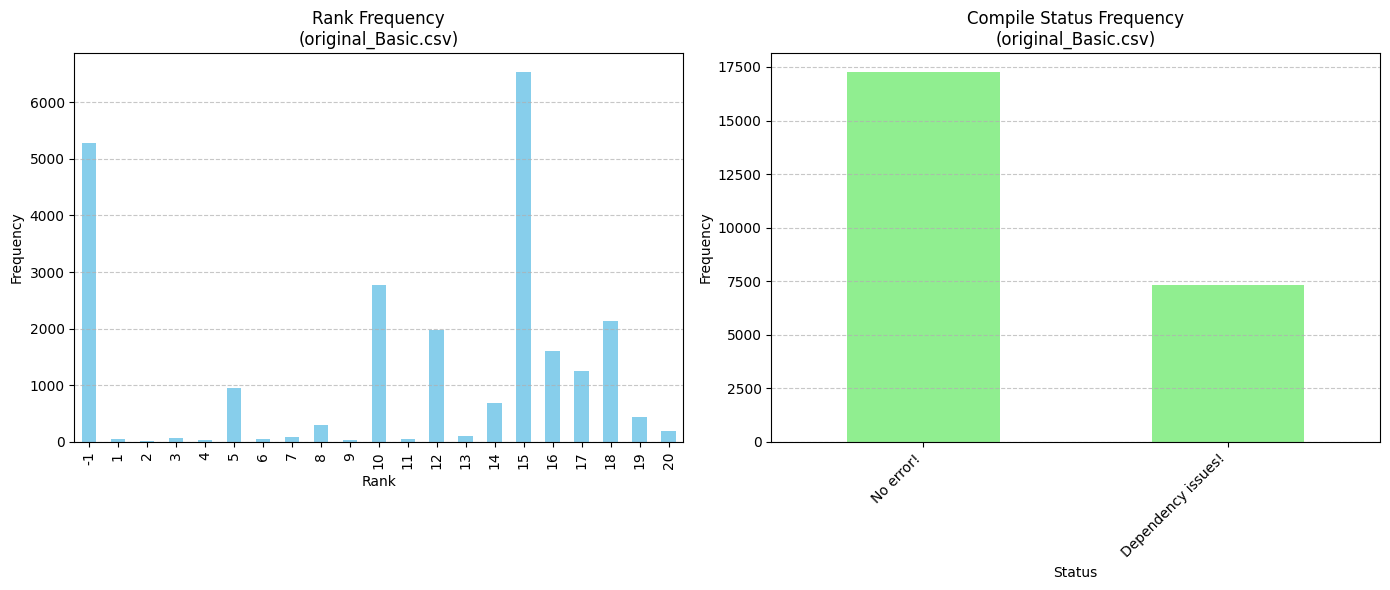


Processing file: original_Intermediate.csv


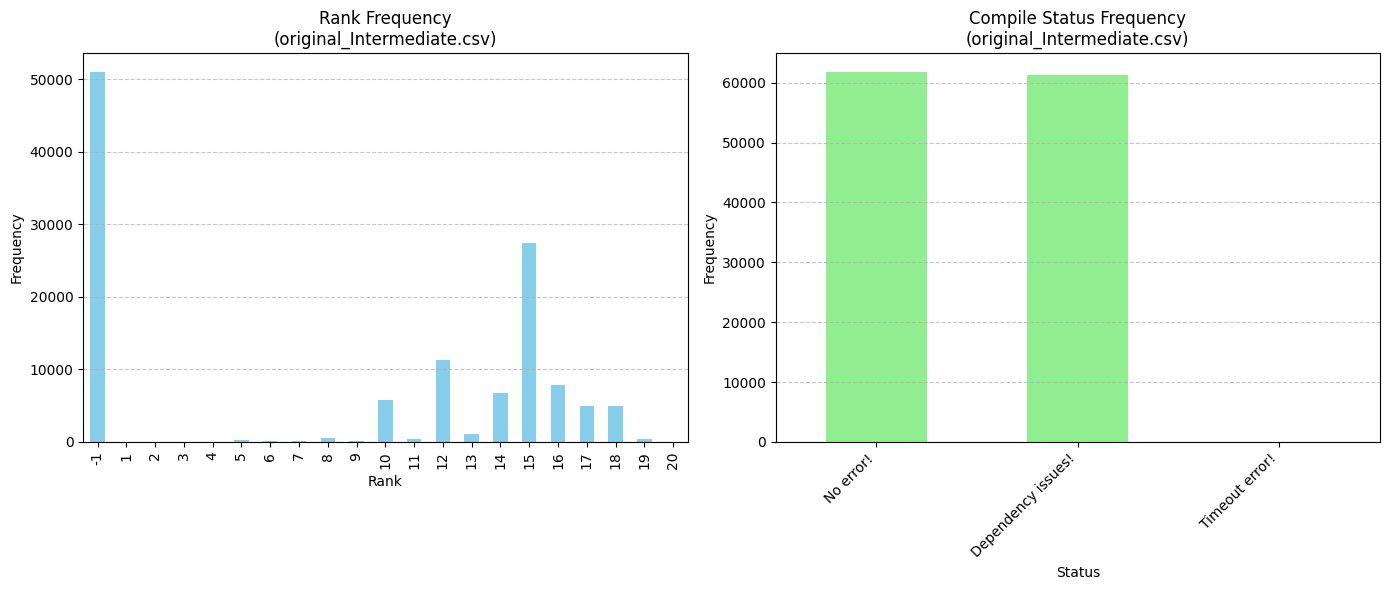


Processing file: original_Expert.csv


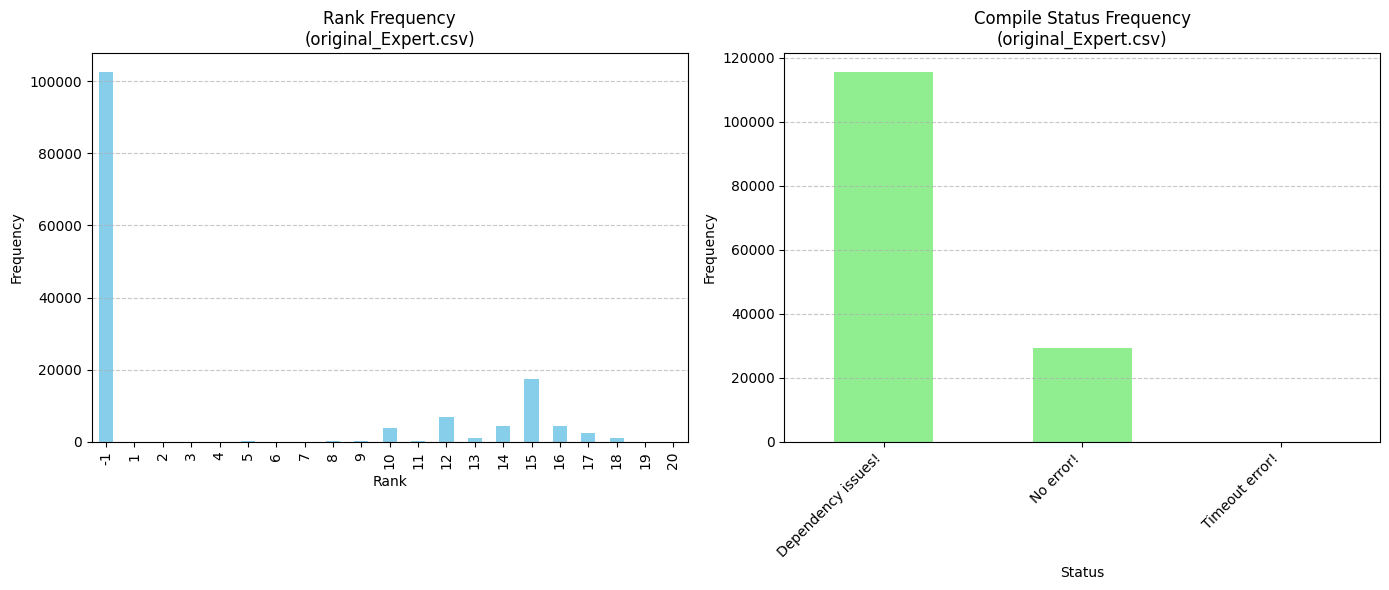


Processing file: original_Advanced.csv


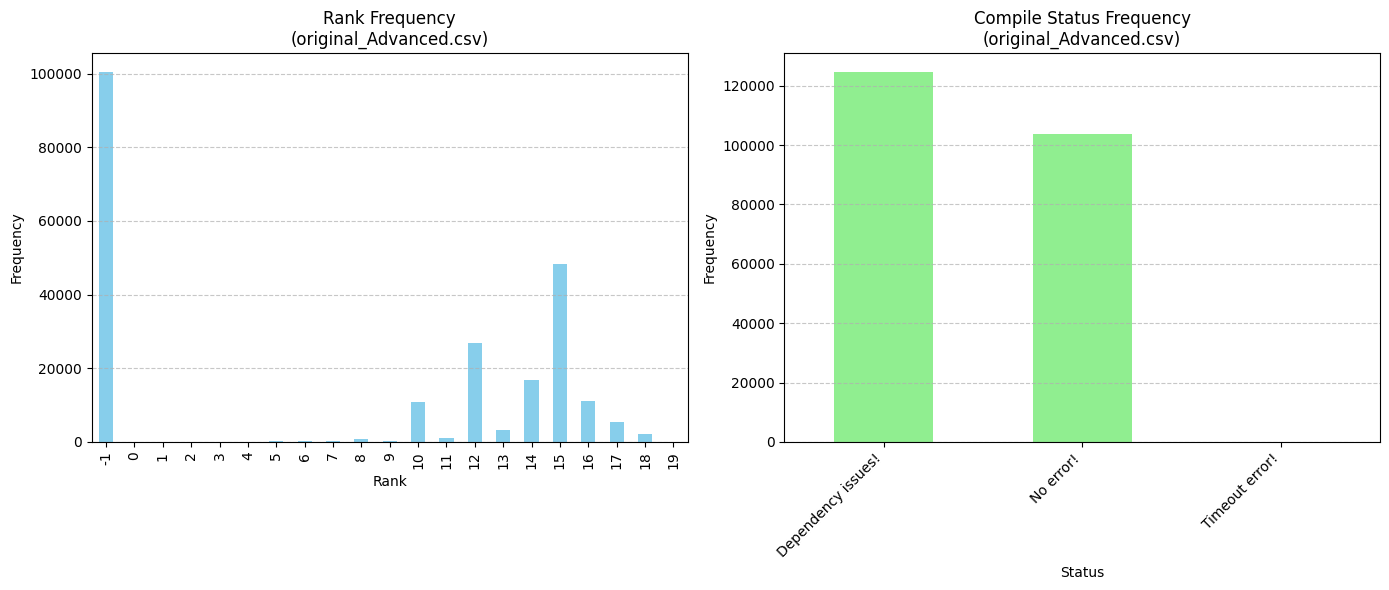


Visualization complete for all files!


In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_frequency_charts(csv_path):
    """Generate frequency charts for rank and compile_status columns"""
    try:
        # Read CSV file
        df = pd.read_csv(csv_path)
        filename = os.path.basename(csv_path)

        # Create figure with two subplots
        plt.figure(figsize=(14, 6))

        # Plot 1: Rank frequency
        plt.subplot(1, 2, 1)
        if 'rank' in df.columns:
            rank_counts = df['rank'].value_counts().sort_index()
            rank_counts.plot(kind='bar', color='skyblue')
            plt.title(f'Rank Frequency\n({filename})')
            plt.xlabel('Rank')
            plt.ylabel('Frequency')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        else:
            plt.text(0.5, 0.5, "'rank' column not found",
                    ha='center', va='center')
            plt.title('Rank Frequency - Data Not Available')

        # Plot 2: Compile Status frequency
        plt.subplot(1, 2, 2)
        if 'compile_status' in df.columns:
            status_counts = df['compile_status'].value_counts()
            status_counts.plot(kind='bar', color='lightgreen')
            plt.title(f'Compile Status Frequency\n({filename})')
            plt.xlabel('Status')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        else:
            plt.text(0.5, 0.5, "'compile_status' column not found",
                    ha='center', va='center')
            plt.title('Compile Status - Data Not Available')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {csv_path}: {str(e)}")

def process_directory(directory_path):
    """Process all CSV files in the directory"""
    if not os.path.exists(directory_path):
        print(f"Directory does not exist: {directory_path}")
        return

    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    if not csv_files:
        print("No CSV files found in the directory")
        return

    for csv_file in csv_files:
        csv_path = os.path.join(directory_path, csv_file)
        print(f"\nProcessing file: {csv_file}")
        plot_frequency_charts(csv_path)


# Set your directory path here
directory_path = "/content/drive/MyDrive/Verilog_dataset/complexity_datasets"  # Replace with your directory path

print("CSV Data Visualization Tool")
print(f"Processing files in: {directory_path}")
process_directory(directory_path)
print("\nVisualization complete for all files!")